In [1]:
import warnings
warnings.filterwarnings('ignore')
# % pip install pandas
# % pip install matplotlib
# % pip install numpy
# % pip install instaloader
import instaloader
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import numpy as np

import reelscraper as rs

plt.style.use("fast")


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':11})
plt.rcParams['axes.linewidth'] = 1.5
plt.rc('axes',edgecolor='black')

In [2]:
# Creating an instance of the Instaloader class
bot = instaloader.Instaloader()

In [2]:
# Create and connect to database
conn = sqlite3.connect("instagram_artists_apresearch.db")
cursor = conn.cursor()

cmd = ""

We will have 2 tables, one for the profiles and one for the posts.
Both tables will contain both human and ai content, with a column identifying which they are

In [ ]:
# create table of all profiles
# column is_human is true if profile is a human artist
cmd = """CREATE TABLE PROFILES(
    user_id INT,
    username VARCHAR(30),
    num_followers INT,
    num_posts INT,
    is_human BOOLEAN,
    PRIMARY KEY (user_id)
    );"""
cursor.execute(cmd)

# create table of all posts
cmd = """CREATE TABLE POSTS(
owner_user_id INT,
owner_username VARCHAR(30),
num_likes INT,
num_comments INT,
shortcode VARCHAR(255),
img_url VARCHAR(255),
post_date DATE,
is_reel BOOLEAN,
FOREIGN KEY(owner_user_id) REFERENCES PROFILES(user_id)
);"""
cursor.execute(cmd)

### Adding data into our sql database and tables

We will create our tables using .csv files. Files must formatted so the first row are column names and thefirst column will not contain information.

#### NOTE Only values outside of the first row and column will be added into the table

In [ ]:
def add_to_tables(csv_path, is_human_val):
    # is_human_val is whether the csv contains human or ai artist profiles

    conn = sqlite3.connect("instagram_artists_apresearch.db")
    cursor = conn.cursor()

    df = pd.read_csv(csv_path)

    start_profile = "" # empty if starting at beginning of csv else set it to what profile you need to start adding
    after_post = "" # empty if starting at beginning of profile or csv else set it to what post you want to start adding after
    past_post = len(after_post) == 0 # False if you need to only add posts after a specific post within a profile (will continue adding profiles after)
    # if past_post is False, past_profile must be False
    past_profile = past_post and (len(start_profile) == 0) # False if you need to only add profiles starting at a specific profile or post


    for i in df.index:
        for col in df.columns[1:]:
            curr_post = None
            curr_profile = None
            try:
                if(pd.notna(df.loc[i,col])):
                    curr_profile = df.loc[i,col]
                    print(curr_profile)
                    ## used to start adding profiles at a profile or post (profile inclusive, post exclusive)
                    if(curr_profile == start_profile):
                        past_profile = True
                    
                    if(past_profile):
                        p = instaloader.Profile.from_username(bot.context, df.loc[i,col]) # grab profile from instagram
                        print(f"{p.userid}, {p.username}, {p.followers}, {p.mediacount}, {is_human_val}, {df.iloc[i,0]}") # track current profile

                        # check if profile does not already exist in table
                        cursor.execute("SELECT 1 FROM PROFILES WHERE USER_ID = {}".format(p.userid))
                        existing_row = cursor.fetchone()

                        if not existing_row:
                            # insert the row
                            cmd= """INSERT INTO PROFILES(USER_ID, USERNAME, NUM_FOLLOWERS, NUM_POSTS, IS_HUMAN, GENRE) 
                                    VALUES ({}, "{}", {}, {}, {}, "{}");""".format(
                                        p.userid, p.username, p.followers, p.mediacount, is_human_val, df.iloc[i,0]
                                    )
                            cursor.execute(cmd)
                        
                        # add all posts from profile's main feed
                        # this includes reels, but we will edit this later
                        for post in p.get_posts():
                            if(past_post):
                                curr_post = post.shortcode + " on main" # keep track of current post which was added
                                cmd= """INSERT INTO POSTS(OWNER_USER_ID, OWNER_USERNAME, NUM_LIKES, NUM_COMMENTS, SHORTCODE, POST_DATE, IS_REEL, IS_HUMAN) 
                                        VALUES ({}, "{}", {}, {}, "{}", "{}", {}, {});""".format(
                                            post.owner_id, post.owner_username, post.likes, post.comments, post.shortcode, post.date_utc, False, is_human_val
                                        ) # is_reel column is set to False regardless if it is a reel or not
                                cursor.execute(cmd)
                            ## used to start adding after a specific post (post exclusive). this post should already be included in the table
                            ## uses post shortcode as identifier
                            # if (post.shortcode == after_post):
                            #     past_post = True
                        
                        # add all reels from a profile's reel tab
                        for reel in rs.from_user_get_reels(df.loc[i,col]):
                            if(past_post):
                                # check if reel was already added via main feed
                                cmd= """SELECT EXISTS(SELECT 1 FROM POSTS WHERE shortcode = "{}")""".format(reel)
                                cursor.execute(cmd)
                                exists = cursor.fetchone()[0]

                                if(exists):
                                    # if it was already added, set the is_reel value to True
                                    cmd= """UPDATE POSTS
                                            SET IS_REEL = TRUE
                                            WHERE shortcode = '{}'""".format(reel)
                                else:
                                    # grab reel data from instagram
                                    post = instaloader.Post.from_shortcode(bot.context, reel)
                                    cmd= """INSERT OR IGNORE INTO POSTS(OWNER_USER_ID, OWNER_USERNAME, NUM_LIKES, NUM_COMMENTS, SHORTCODE, POST_DATE, IS_REEL, IS_HUMAN) 
                                            VALUES ({}, "{}", {}, {}, "{}", "{}", {}, {});""".format(
                                                post.owner_id, post.owner_username, post.likes, post.comments, post.shortcode, post.date_utc, True, is_human_val
                                            ) # is_reel value is True
                                cursor.execute(cmd)
                                curr_post = reel + " on reels"
                            # if (reel == after_post):
                            #     past_post = True
                        conn.commit() # commit data after every profile
                                
            # exception handling mainly for profiles not found, faulty networks connections, or instagram blocking us temporarily
            # this helps keep track of and continue where we left off, which is why we have the past_profile and past_post
            except Exception as e:
                conn.commit()
                conn.close()
                print(f"Error with {df.loc[i,col]}, after {curr_post} : {e}")
                return
    # IMPORTANT finally save all changes to database, changes are not committed every insert
    # conn.commit()
    conn.close()

In [ ]:
add_to_tables("HA.csv", True) # add human profiles and posts into tables

In [ ]:
add_to_tables("AIA.csv", False) # add AI profiles and posts into tables

In [3]:
cmd= """SELECT POSTS.*
        FROM POSTS
        """
posts_df = pd.read_sql(cmd, conn)
# convert to dataframe
posts_df['post_date'] = pd.to_datetime(posts_df['post_date'])

In [4]:
cmd= """SELECT PROFILES.*
        FROM PROFILES
        """
# convert to dataframe
profiles_df = pd.read_sql(cmd, conn)

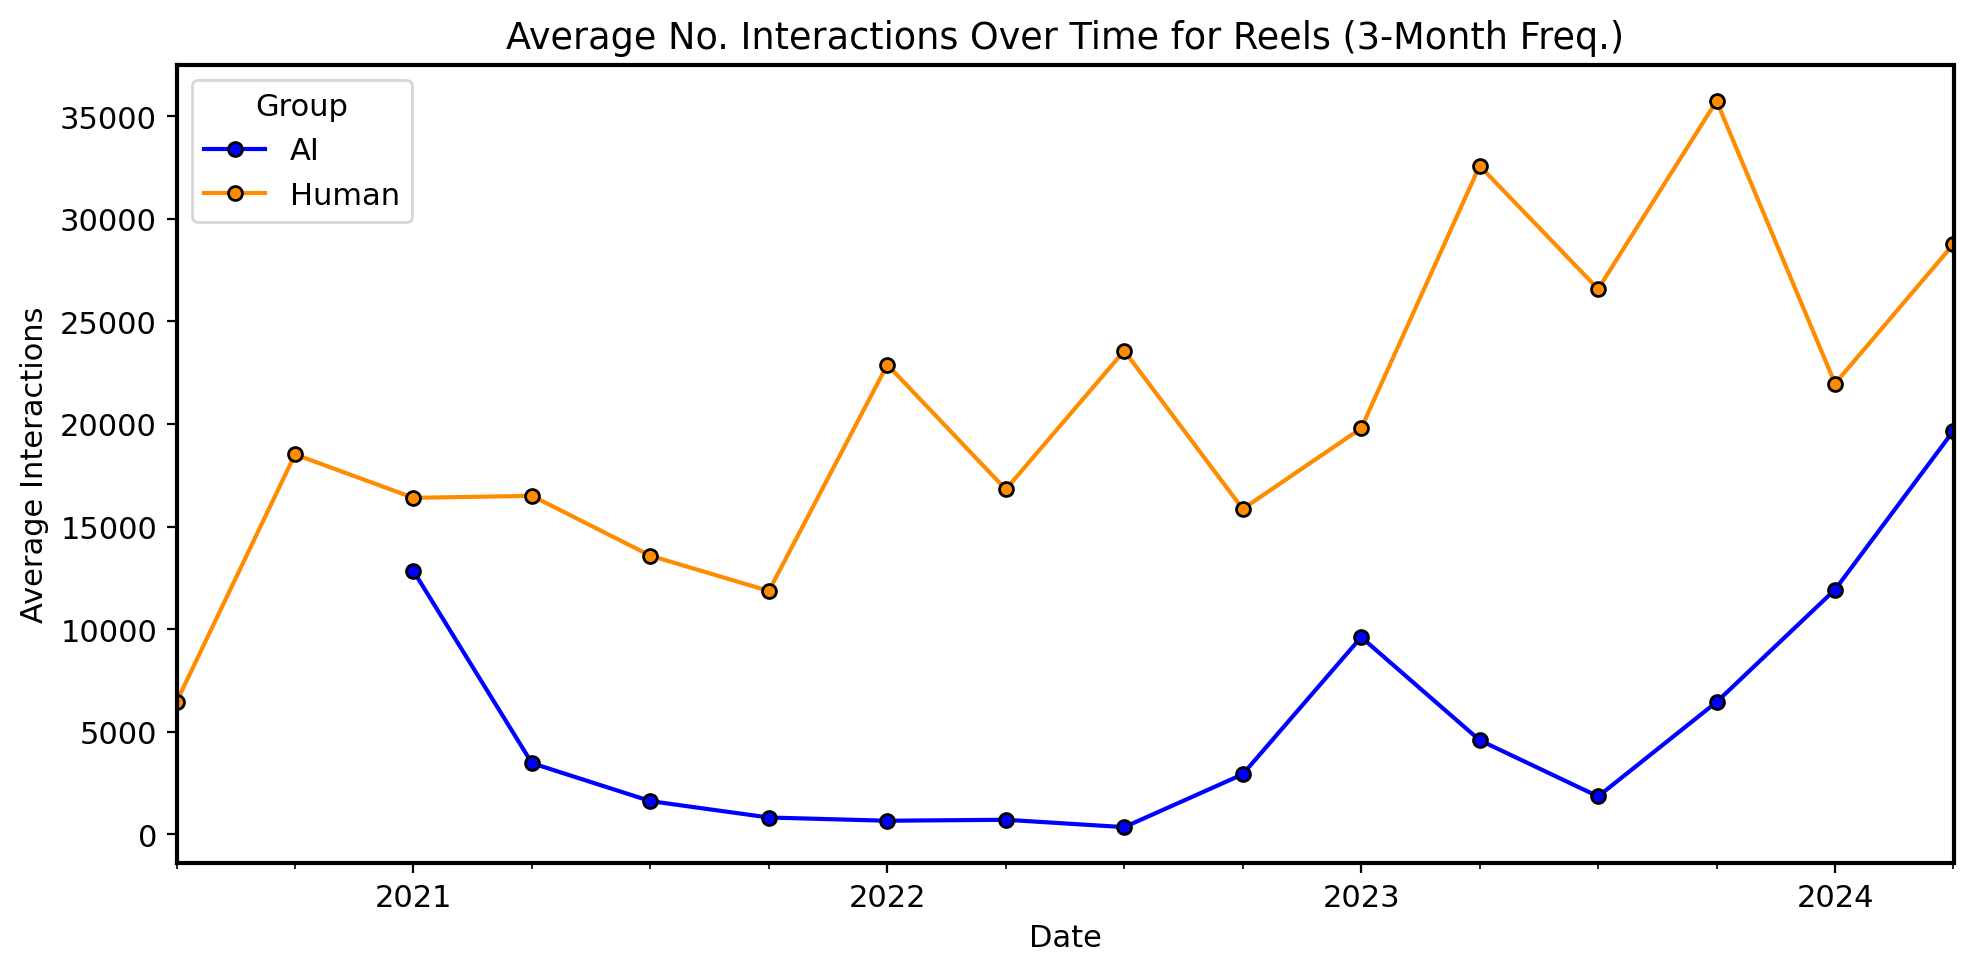

In [30]:
filtered_df = posts_df[(posts_df['num_likes'] >= 0) & (posts_df['is_reel'] == 1) & (posts_df['post_date'] >= "2020-08-05")]

date_freq = "3M"
# Calculate average likes per group and date
avg_likes = filtered_df.groupby(['is_human', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].mean().reset_index()
# avg_likes = filtered_df.groupby(["owner_username", pd.Grouper(key='owner_username')])['num_likes'].mean().reset_index()

# Pivot the data for easier plotting
pivot_df = avg_likes.pivot(index='post_date', columns='is_human', values='num_likes')

# Plotting
pivot_df.plot(kind='line', marker="o", markeredgecolor= "black", markersize= 5, figsize=(10, 5), color= ['blue', 'darkorange'])
plt.title('Average No. Interactions Over Time for Reels (3-Month Freq.)')
plt.xlabel('Date')
plt.ylabel('Average Interactions')

plt.legend(title='Group', labels= ["AI", "Human"])
plt.tight_layout()
plt.show()

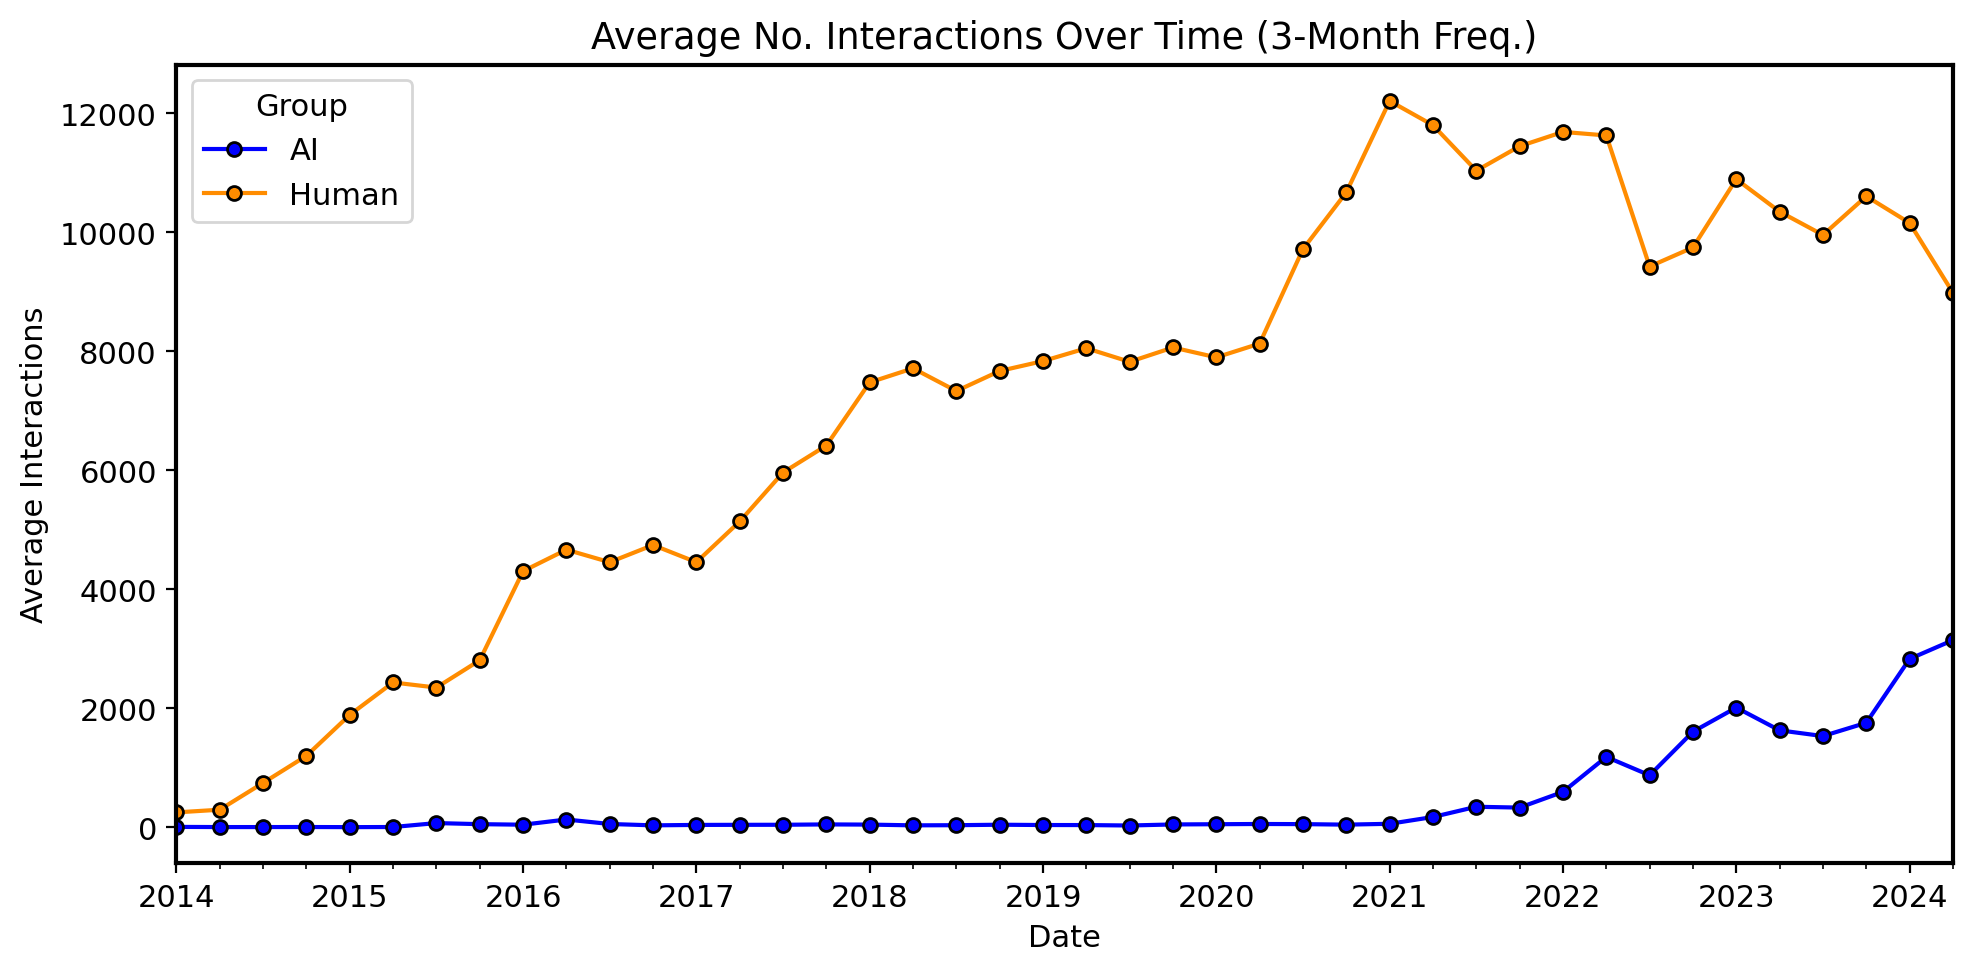

In [6]:
filtered_df = posts_df[(posts_df['num_likes'] >= 0) & (posts_df['is_reel'] == 0) & (posts_df['post_date'] >= "2014-01-01")]
merged_dfe= pd.merge(filtered_df, profiles_df, left_on='owner_username', right_on='username')

merged_dfe["ER"] = (merged_dfe["num_likes"] + merged_dfe["num_comments"])

# Calculate average likes per group and date
avg_likes = merged_dfe.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)])['ER'].mean().reset_index()

# Pivot the data for easier plotting
pivot_df = avg_likes.pivot(index='post_date', columns='is_human_x', values='ER')

# Plotting
pivot_df.plot(kind='line', marker="o", markeredgecolor= "black", markersize= 5, figsize=(10, 5), color= ['blue', 'darkorange'])
plt.title(f'Average No. Interactions Over Time (3-Month Freq.)')
plt.xlabel('Date')
plt.ylabel('Average Interactions')
plt.grid(False)
plt.legend(title='Group', labels= ["AI", "Human"])

plt.tight_layout()
plt.show()

In [7]:
merged_dfe["first_post_on_profile"] = ""

for p in merged_dfe["owner_username"].unique():
    merged_dfe.loc[merged_dfe["owner_username"] == p, "first_post_on_profile"] = merged_dfe[merged_dfe["owner_username"] == p]["post_date"].min()

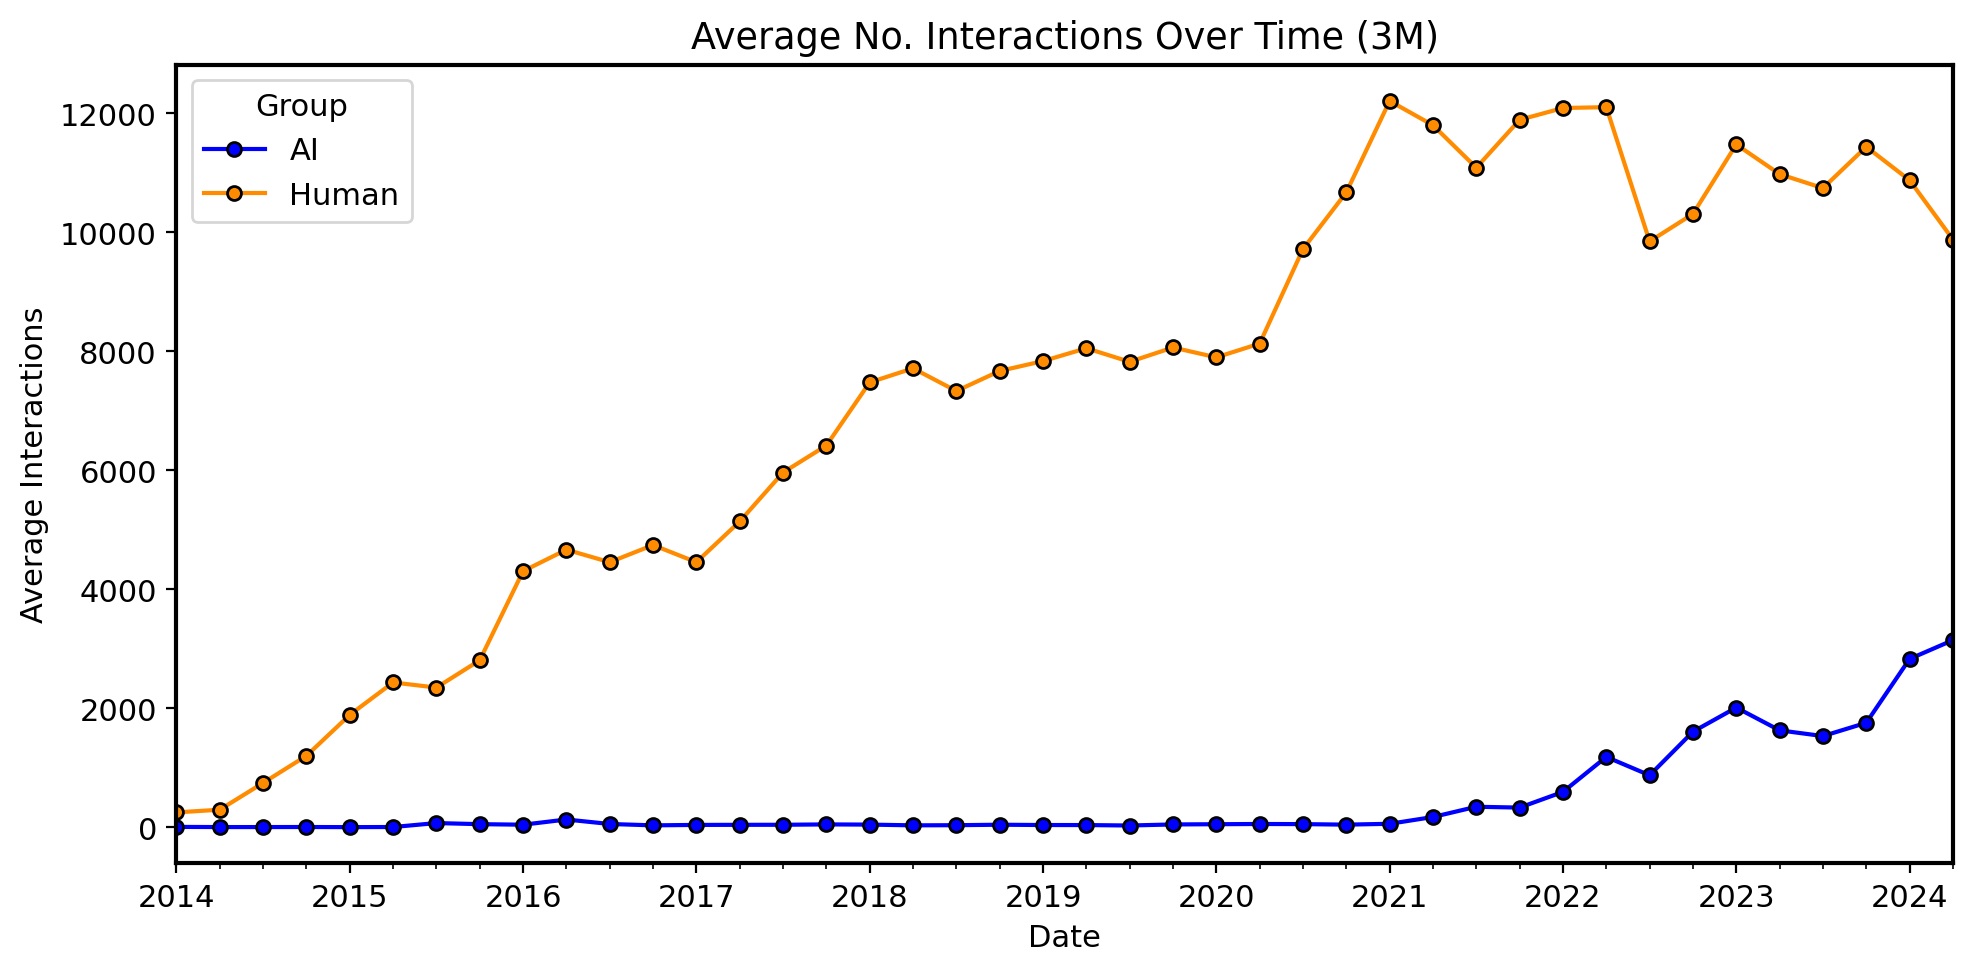

In [195]:
# merged_dfb = merged_dfe[(merged_dfe["first_post_on_profile"] < np.datetime64("2021-04-01")) | (merged_dfe["is_human_x"] == 0)]

# # Calculate average likes per group and date
# avg_likes = merged_dfb.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)])['ER'].mean().reset_index()

# # Pivot the data for easier plotting
# pivot_df = avg_likes.pivot(index='post_date', columns='is_human_x', values='ER')

# # Plotting
# pivot_df.plot(kind='line', marker="o", markeredgecolor= "black", markersize= 5, figsize=(10, 5), color= ['blue', 'darkorange'])
# plt.title(f'Average No. Interactions Over Time ({date_freq})')
# plt.xlabel('Date')
# plt.ylabel('Average Interactions')
# plt.grid(False)
# plt.legend(title='Group', labels= ["AI", "Human"])

# plt.tight_layout()
# plt.show()

In [8]:
f = avg_likes[avg_likes["is_human_x"] == 0].reset_index()
f2 = avg_likes[avg_likes["is_human_x"] == 1].reset_index()

In [9]:
import pwlf
from piecewise_regression import davies_test
def summary(sr: pwlf.PiecewiseLinFit):
    print("Segmented Regression Results")
    print("------------------------------")
    print(f"No. Observations: {sr.n_data}")
    print(f"No. Breakpoints: {sr.n_parameters - 2}")
    print(f"Sum of Squares: {sr.ssr}")
    print(f"Total Sum of Squares: {sr.ssr/ sr.r_squared()}")
    print(f"R^2: {sr.r_squared()}")
    print("------------------------------")
    params = sr.beta
    se = sr.standard_errors()
    pv = sr.p_values()
    print(f"b1: Estimate={params[0]}    Std. Err={se[0]}    p-value={pv[0]}")
    print(f"b2: Estimate={params[1]}    Std. Err={se[1]}    p-value={pv[1]}")
    print(f"b3: Estimate={params[2]}    Std. Err={se[2]}    p-value={pv[2]}")
    if len(params) == 4:
        print(f"b4: Estimate={params[3]}    Std. Err={se[3]}    p-value={pv[3]}")
    print(f"a1: Estimate={sr.slopes[-1]}")
    date = f2.iloc[int(np.ceil(sr.fit_breaks[-2:-1])), 2].strftime("%Y-%m")
    print(f"breakpoint (estimate if not known): {sr.fit_breaks[1:-1]} = {date}")
    print("-------------------------------")
    print(f"Davies test for existence of at least 1 breakpoint: p={davies_test(sr.x_data, sr.y_data)}")
    print(f"(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)")

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 1290794.486763385
Total Sum of Squares: 1356343.215198061
R^2: 0.9516724618811883
------------------------------
b1: Estimate=15.214229082229663    Std. Err=62.68413821395421    p-value=0.8095000260296112
b2: Estimate=1.8889269437554717    Std. Err=3.4213923845863157    p-value=0.5840348069468528
b3: Estimate=228.31893007262408    Std. Err=12.443128043960984    p-value=8.767657380598834e-21
a1: Estimate=230.20785701637953
breakpoint (estimate if not known): [29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=2.4095107205102994e-57
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


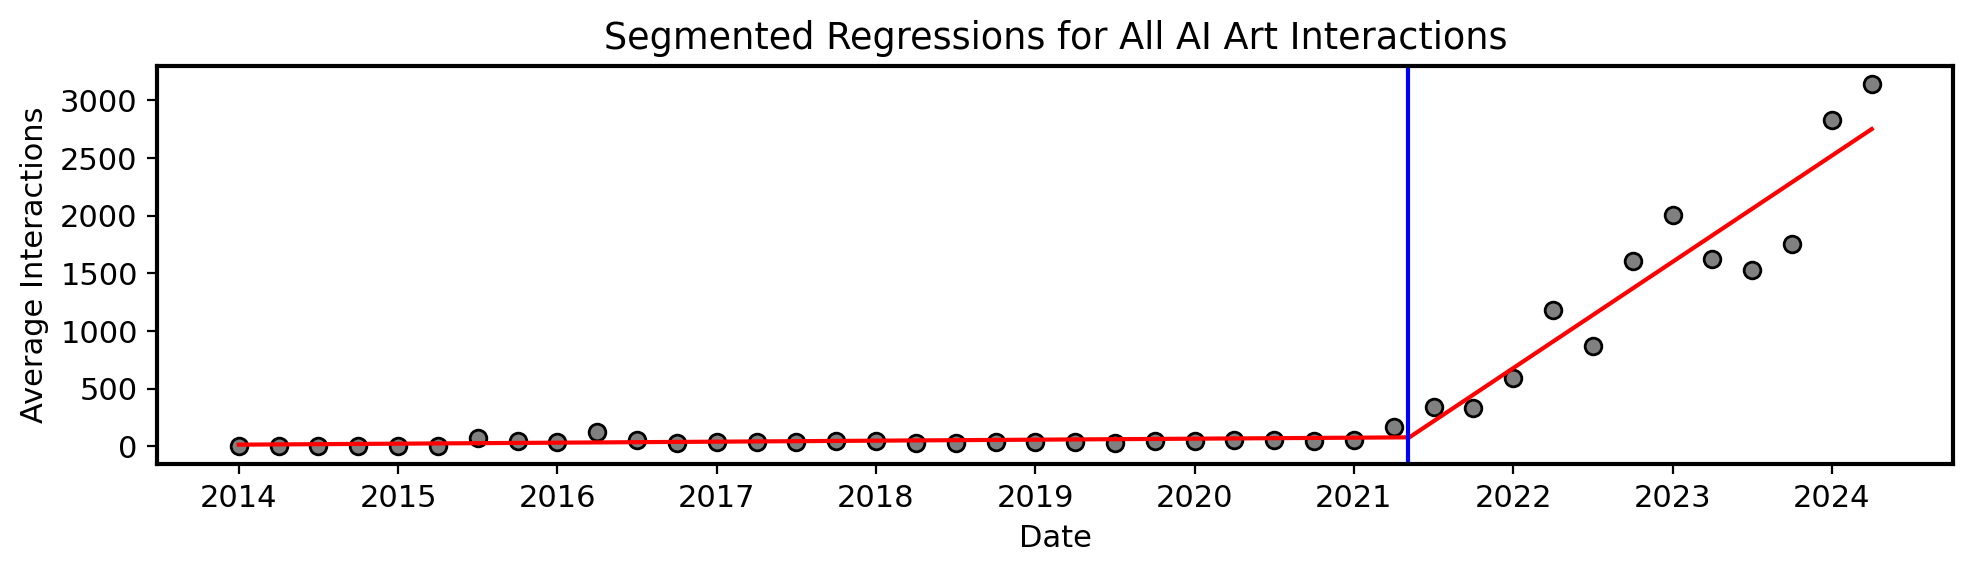

In [10]:

fig, ax = plt.subplots(figsize=(10, 3))
# initialize piecewise linear fit with your x and y data
x = np.array(f.index)
y = np.array(f['ER'])
aisr = pwlf.PiecewiseLinFit(np.array(f.index), np.array(f['ER']), disp_res= False)

# fit the data for 2 line segments
res = aisr.fit(2)
summary(aisr)

# predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = aisr.predict(xHat)

ax.plot(np.array(f.index), np.array(f['ER']), 'o', color= "grey", markeredgecolor= "black")
ax.plot(xHat, yHat, '-', color= 'red')
ax.set_xticks(f2.index, minor=False, labels=pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)
ax.axvline(aisr.fit_breaks[1], color= "blue")
ax.set_title("Segmented Regressions for All AI Art Interactions")
ax.set_ylabel("Average Interactions")
ax.set_xlabel("Date")
plt.locator_params(nbins=11)
plt.tight_layout()

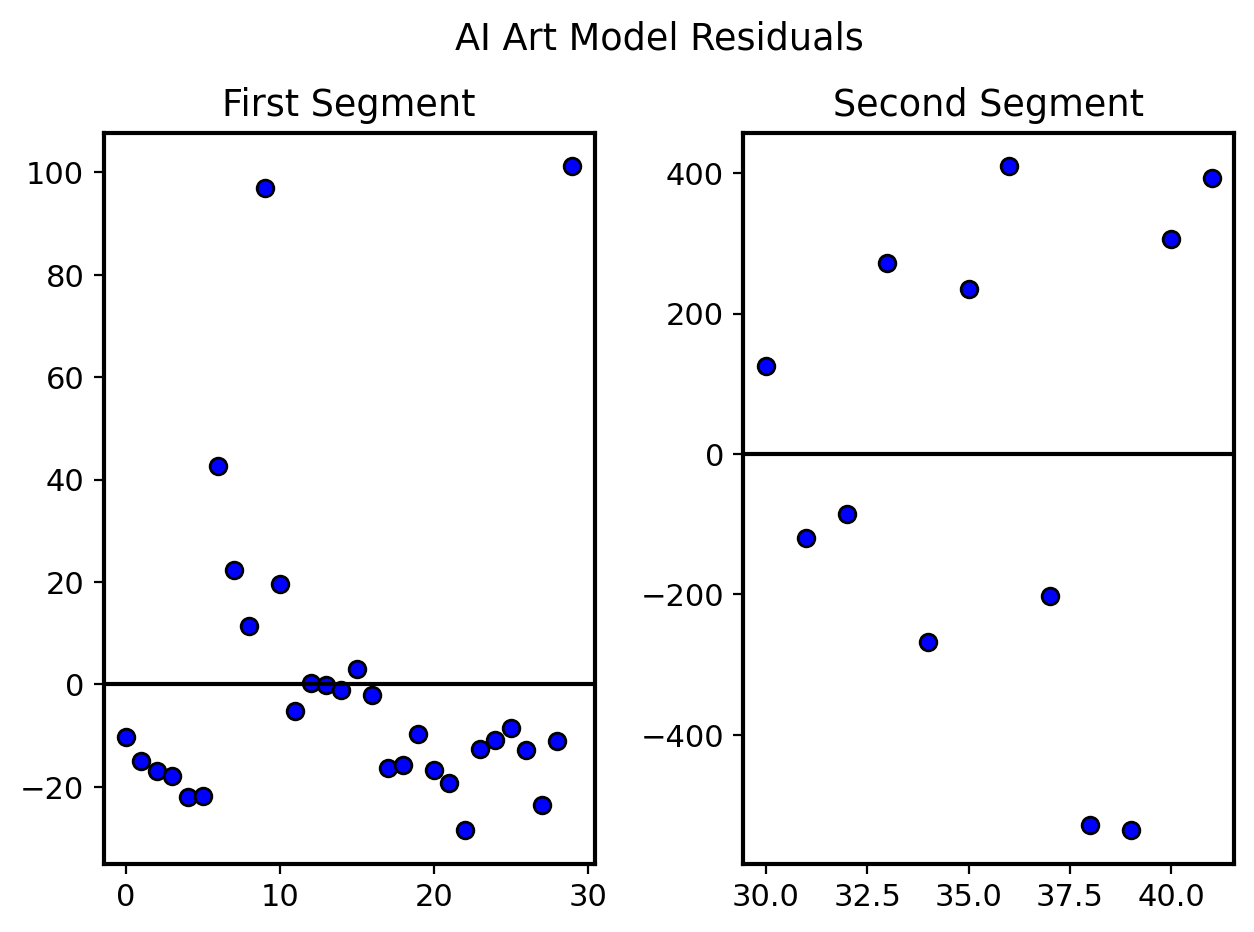

In [11]:
xHat = np.linspace(min(x), max(x), num=len(x))
yHat = aisr.predict(xHat)
ax= plt.subplot(1, 2, 1)
ax.plot(x[:-12], (y - yHat)[:-12], "bo", markeredgecolor= "black")
ax.axhline(0, color= "black")
plt.title('First Segment')

ax = plt.subplot(1, 2, 2)
ax.plot(x[-12:], (y - yHat)[-12:], "bo", markeredgecolor= "black")
ax.axhline(0, color= "black")
plt.title('Second Segment')

plt.suptitle('AI Art Model Residuals', x= 0.525, y= 0.965)

plt.tight_layout()
plt.show()

In [17]:
def srwbp(y, fs= (10, 3), title="Segmented Regression"):
    fig, ax = plt.subplots(figsize=fs)
    # initialize piecewise linear fit with your x and y data
    x = np.arange(len(y))
    hsr = pwlf.PiecewiseLinFit(x, np.array(y), disp_res= True, degree=1)
    res = hsr.fit_with_breaks(aisr.fit_breaks)
    summary(hsr)
    # predict for the determined points
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = hsr.predict(xHat)

    ax.plot(x, np.array(y), 'o', color= "grey", markeredgecolor= "black")
    ax.plot(xHat, yHat, '-', color= 'red')
    ax.set_xticks(f2.index, minor=False, labels=pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)
    ax.axvline(hsr.fit_breaks[1], color= "blue")
    if title == "Human Art":
        ax.set_title(f"Segmented Regression for {title} Interactions")
    else:
        ax.set_title(f"Segmented Regression for Human Artists with {title} Followers")

    ax.set_ylabel("Average Interactions")
    ax.set_xlabel("Date")
    plt.locator_params(nbins=11)
    plt.tight_layout()
    plt.show()

    xHat = np.linspace(min(x), max(x), num=len(x))

    yHat = hsr.predict(xHat)
    ax= plt.subplot(1, 2, 1)
    ax.plot(x[:-12], (y - yHat)[:-12], "bo", markeredgecolor= "black")
    ax.axhline(0, color= "black")
    plt.title('First Segment')

    ax = plt.subplot(1, 2, 2)
    ax.plot(x[-12:], (y - yHat)[-12:], "bo", markeredgecolor= "black")
    ax.axhline(0, color= "black")
    plt.title('Second Segment')

    plt.suptitle(f'{title} Model Residuals', x= 0.525, y= 0.965)

    plt.tight_layout()
    plt.show()

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 18568070.16381179
Total Sum of Squares: 19259795.21444242
R^2: 0.9640845064587227
------------------------------
b1: Estimate=430.47081476520594    Std. Err=237.745602620885    p-value=0.07790610787325433
b2: Estimate=372.2109475306491    Std. Err=12.976504382968505    p-value=7.926814375013904e-28
b3: Estimate=-518.1161830919655    Std. Err=47.19374086635822    p-value=1.704546969578917e-13
a1: Estimate=-145.9052355613164
breakpoint (estimate if not known): [29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=1.5557287139052677e-28
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


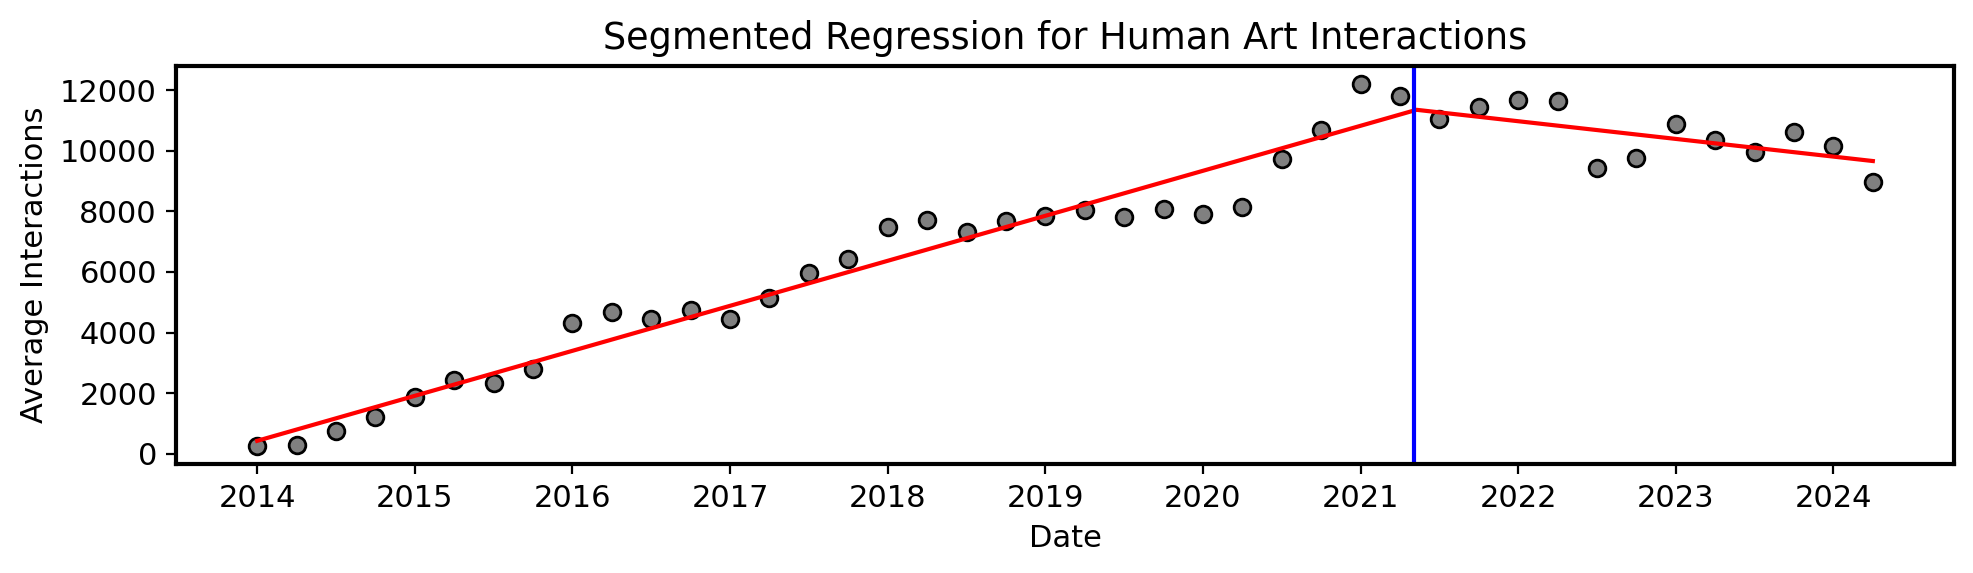

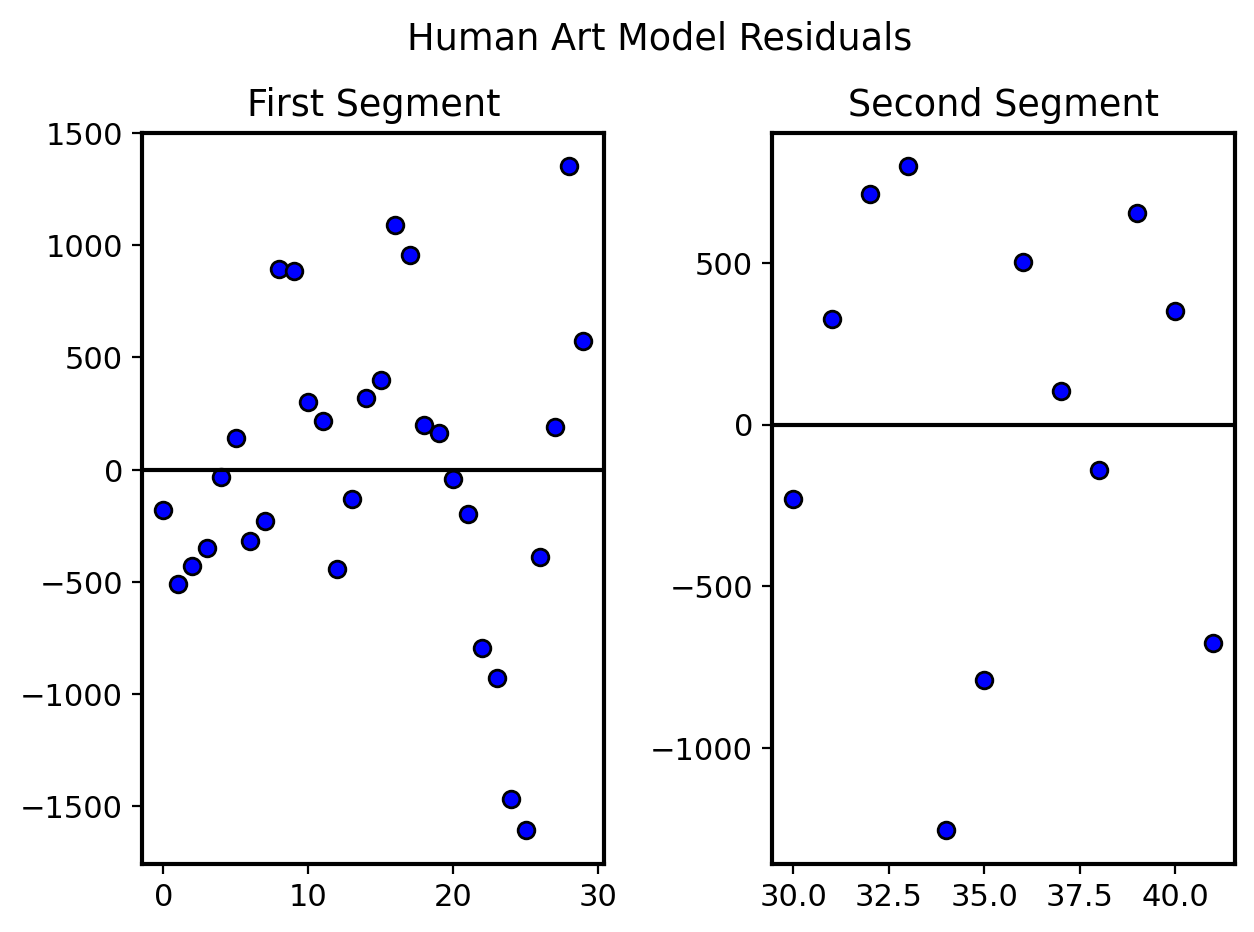

In [18]:
srwbp(f2['ER'], title = "Human Art")

In [19]:
ai_mdf = merged_dfe[merged_dfe["is_human_x"] == 0]
h_mdf = merged_dfe[merged_dfe["is_human_x"] == 1]

In [199]:
# ai_mdf = merged_dfb[merged_dfb["is_human_x"] == 0]
# h_mdf = merged_dfb[merged_dfb["is_human_x"] == 1]

Follower Size Breakdown:
Group:, Count:, %:
(0, 10000]: 4511,   0.042597996166085915
(10000, 50000]: 14876,   0.14047612302520374
(50000, 100000]: 14163,   0.13374316552876853
(100000, 500000]: 34031,   0.32135943416716245
(500000, 100000000]: 38316,   0.3618232811127794


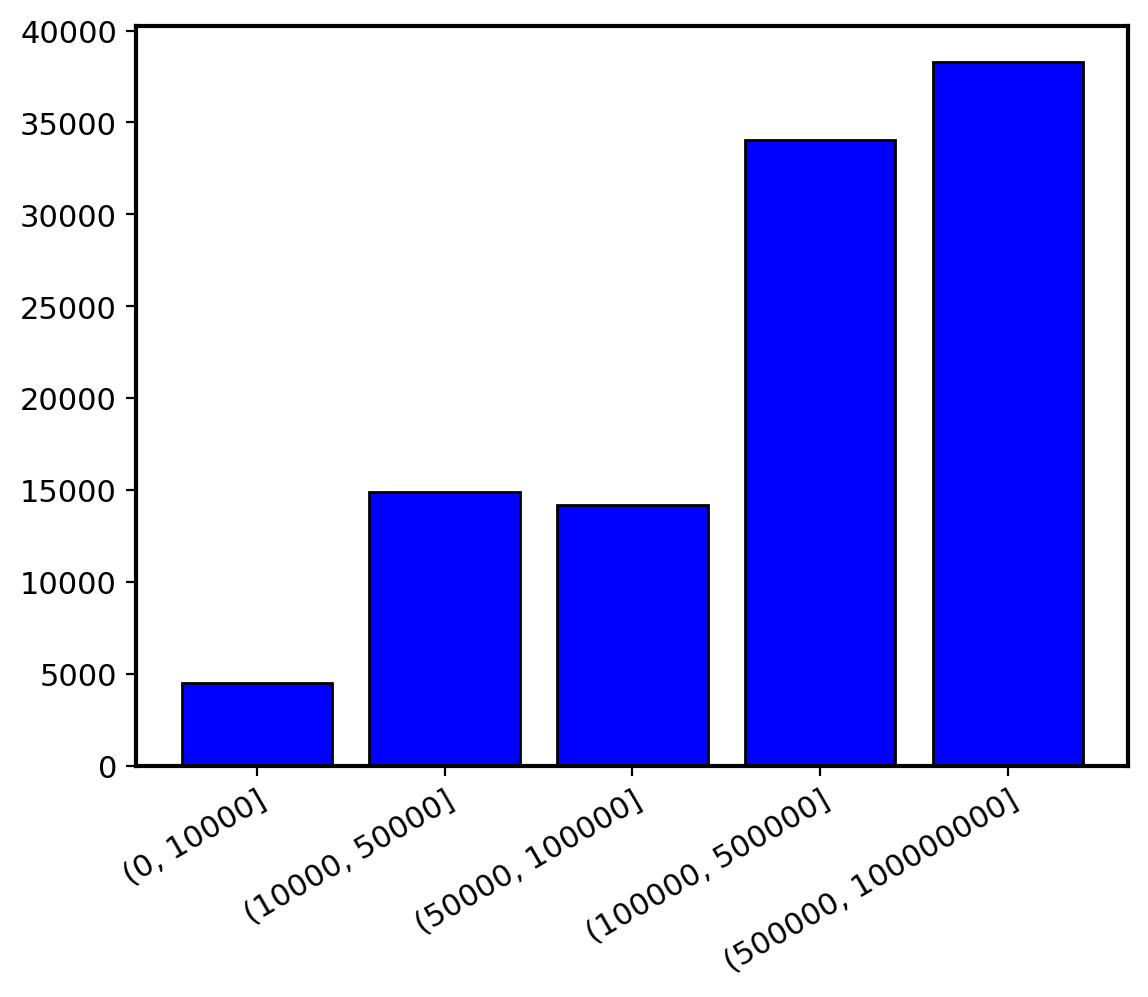

In [20]:
avgh = h_mdf.groupby([pd.cut(merged_dfe['num_followers'], [0, 10000, 50000, 100000, 500000, 100000000])])
cts = {}
for col in pd.cut(merged_dfe['num_followers'], [0, 10000, 50000, 100000, 500000, 100000000]).unique():
    cts[col] = 0

s = []

for group_key, indices in avgh.groups.items():
    group_size = len(indices)
    cts[group_key] += group_size

plt.bar([str(x) for x in cts.keys()], cts.values(), color='b', edgecolor = "black")
plt.xticks(rotation=30, ha='right', rotation_mode="anchor")

print("Follower Size Breakdown:")
print("Group:, Count:, %:")
for c in cts:
    print(f"{c}: {cts[c]},   {cts[c]/h_mdf.shape[0]}")

Art Genres Breakdown:
Group:, Count:, %:
Pixel: 1448,   0.013673664032031125
Digital Painting: 3508,   0.033126528607987
Semi Realism: 3715,   0.03508125820372626
Cartoon: 3959,   0.03738538391078123
Horror: 3998,   0.03775366629838428
Portrait: 4034,   0.03809361927155632
Anime: 4566,   0.04311736876398765
Mecha: 5551,   0.052418859835500535
Character Design: 5870,   0.055431220903330594
Pencil: 6926,   0.0654031747830439
Traditional Painting: 7716,   0.07286325391654154
Fantasy: 8394,   0.07926570157794838
Stylized: 9164,   0.08653691794857267
Fashion: 10352,   0.09775536606325014
Environment/Landscape: 11299,   0.10669801788530364
Comic: 15397,   0.14539599799805472
105897


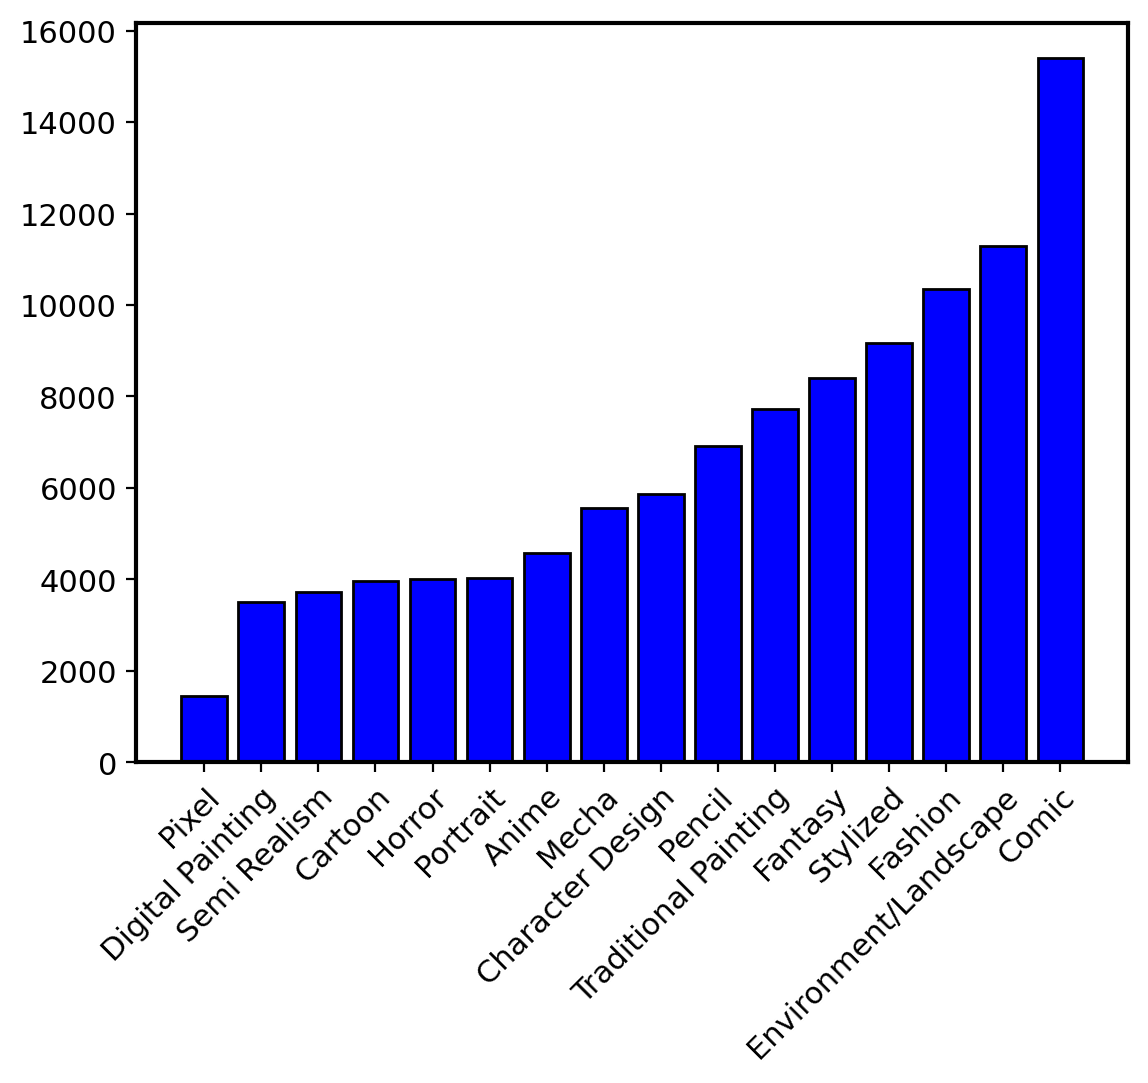

In [21]:
avgh = h_mdf.groupby(h_mdf["genre"])
cts = {}
for col in h_mdf["genre"].unique():
    cts[col] = 0

s = []

for group_key, indices in avgh.groups.items():
    group_size = len(indices)
    cts[group_key] += group_size

total = 0

scts = sorted(cts.items(), key=lambda x:x[1])
scts = dict(scts)

plt.bar(scts.keys(), scts.values(), color='b', edgecolor = "black")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
# plt.tight_layout()
print("Art Genres Breakdown:")
print("Group:, Count:, %:")
for c in scts:
    print(f"{c}: {cts[c]},   {cts[c]/h_mdf.shape[0]}")
    total += cts[c]

print(total)

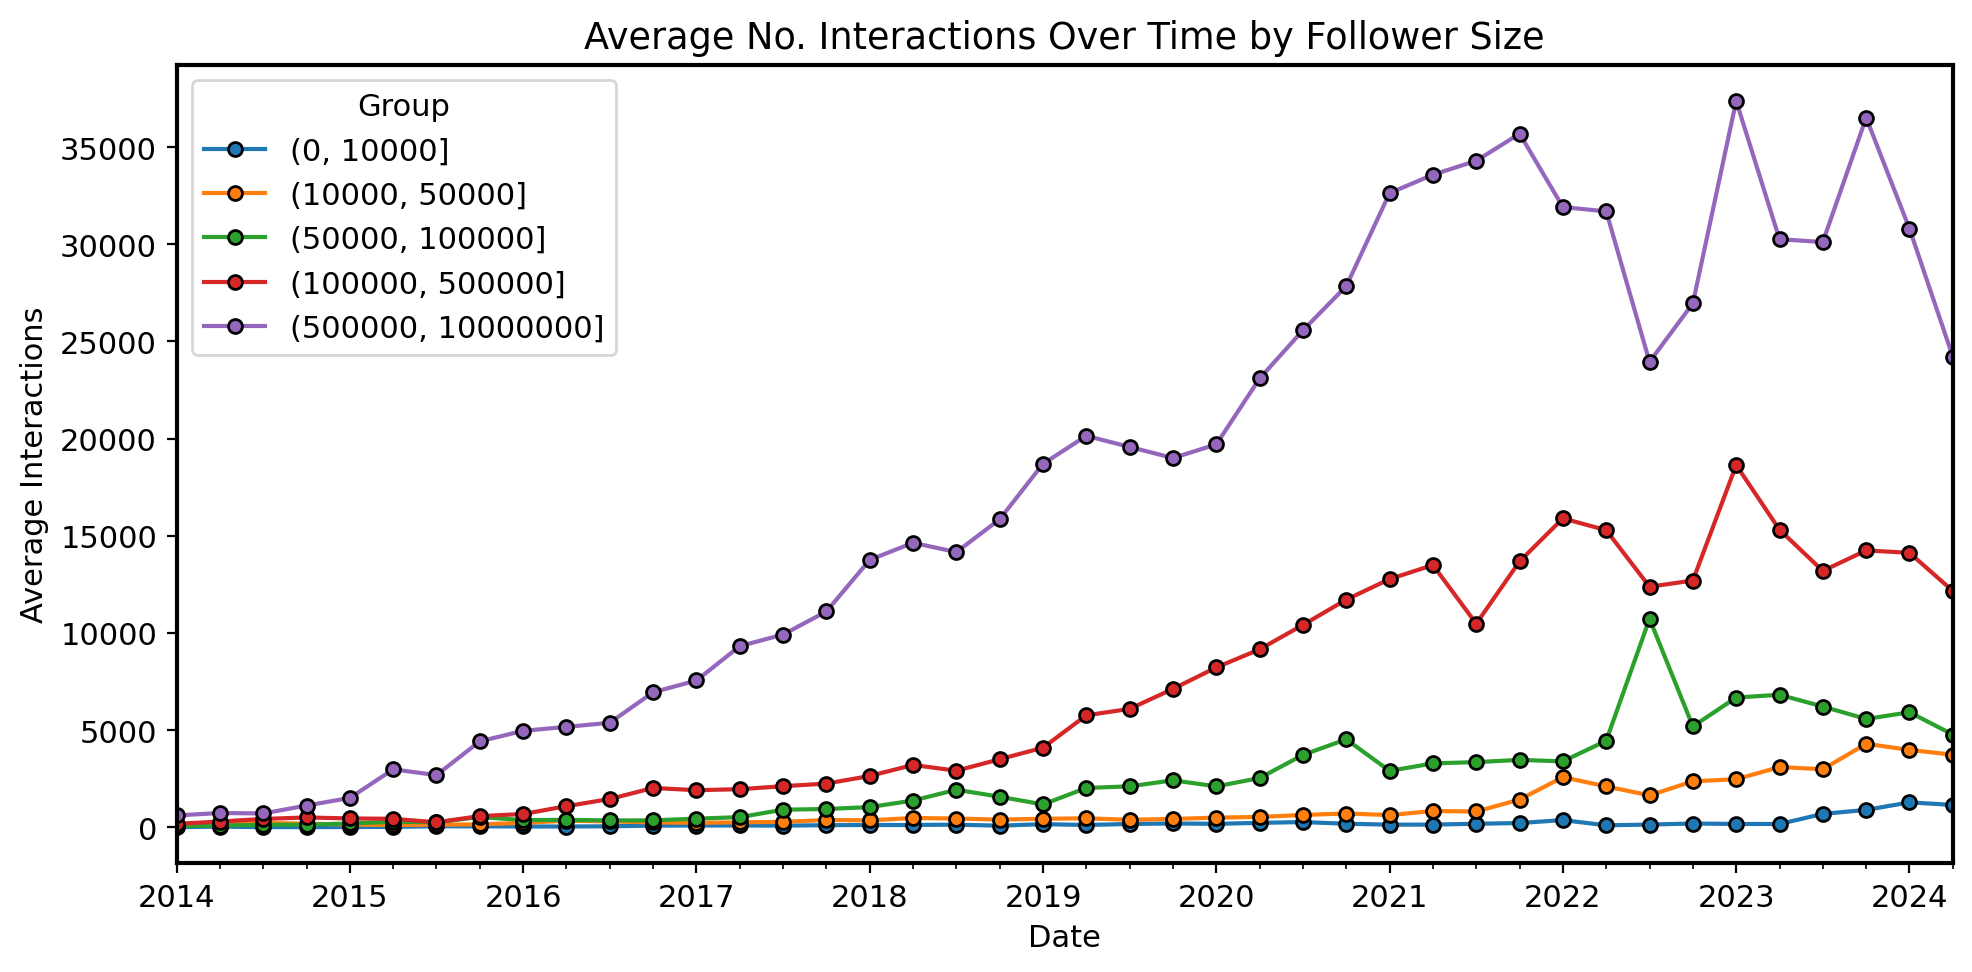

In [29]:
avgh = h_mdf.groupby([pd.Grouper(key='post_date', freq=date_freq), pd.cut(merged_dfe['num_followers'], [0, 10000, 50000, 100000, 500000, 10000000]), h_mdf["genre"]], observed=True)['ER'].mean().reset_index()

data = []
for d in avgh["post_date"].unique():
    for f in avgh[avgh["post_date"] == d]["num_followers"].unique():
        data.append([d, f, avgh[(avgh["post_date"] == d) & (avgh["num_followers"] == f)]["ER"].mean()])
avghf = pd.DataFrame(data, columns=["post_date", "num_followers", "ER"])
pivot_df = avghf.pivot(index='post_date', columns='num_followers', values='ER')

# Plotting
pivot_df.plot(kind='line', marker="o", markeredgecolor= "black", markersize= 5, figsize=(10, 5))
plt.title('Average No. Interactions Over Time by Follower Size')
plt.xlabel('Date')
plt.ylabel('Average Interactions')

plt.legend(title='Group')
plt.tight_layout()
plt.show()

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 981076.4520158257
Total Sum of Squares: 1400739.7002591204
R^2: 0.700398833440887
------------------------------
b1: Estimate=34.64139843112534    Std. Err=54.64878799152857    p-value=0.5298522206602021
b2: Estimate=2.6443677071005016    Std. Err=2.9828111606624144    p-value=0.3807633779040651
b3: Estimate=62.734556777451814    Std. Err=10.848069157541534    p-value=1.0367007325445849e-06
a1: Estimate=65.37892448455231
breakpoint (estimate if not known): [29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=1.0375644205102169e-37
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


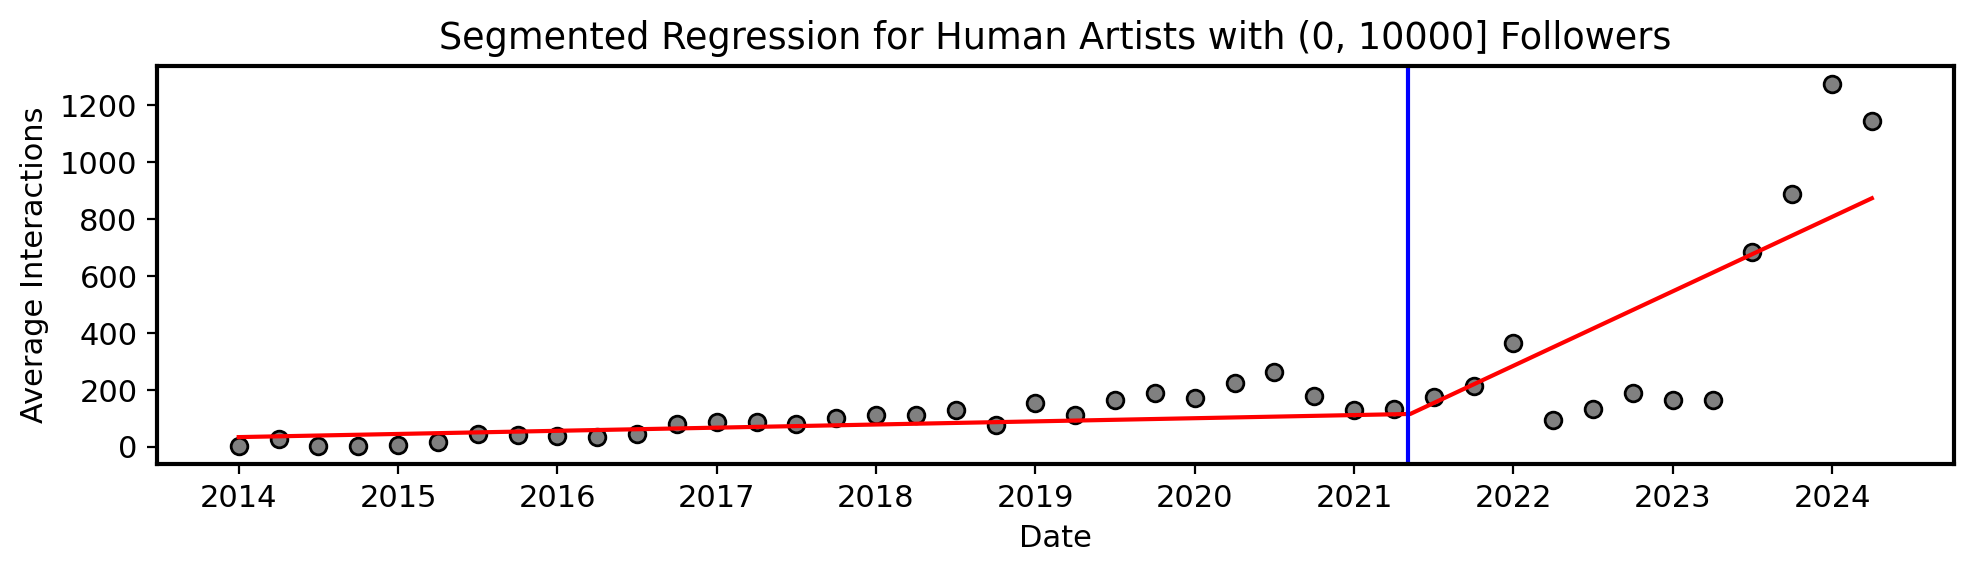

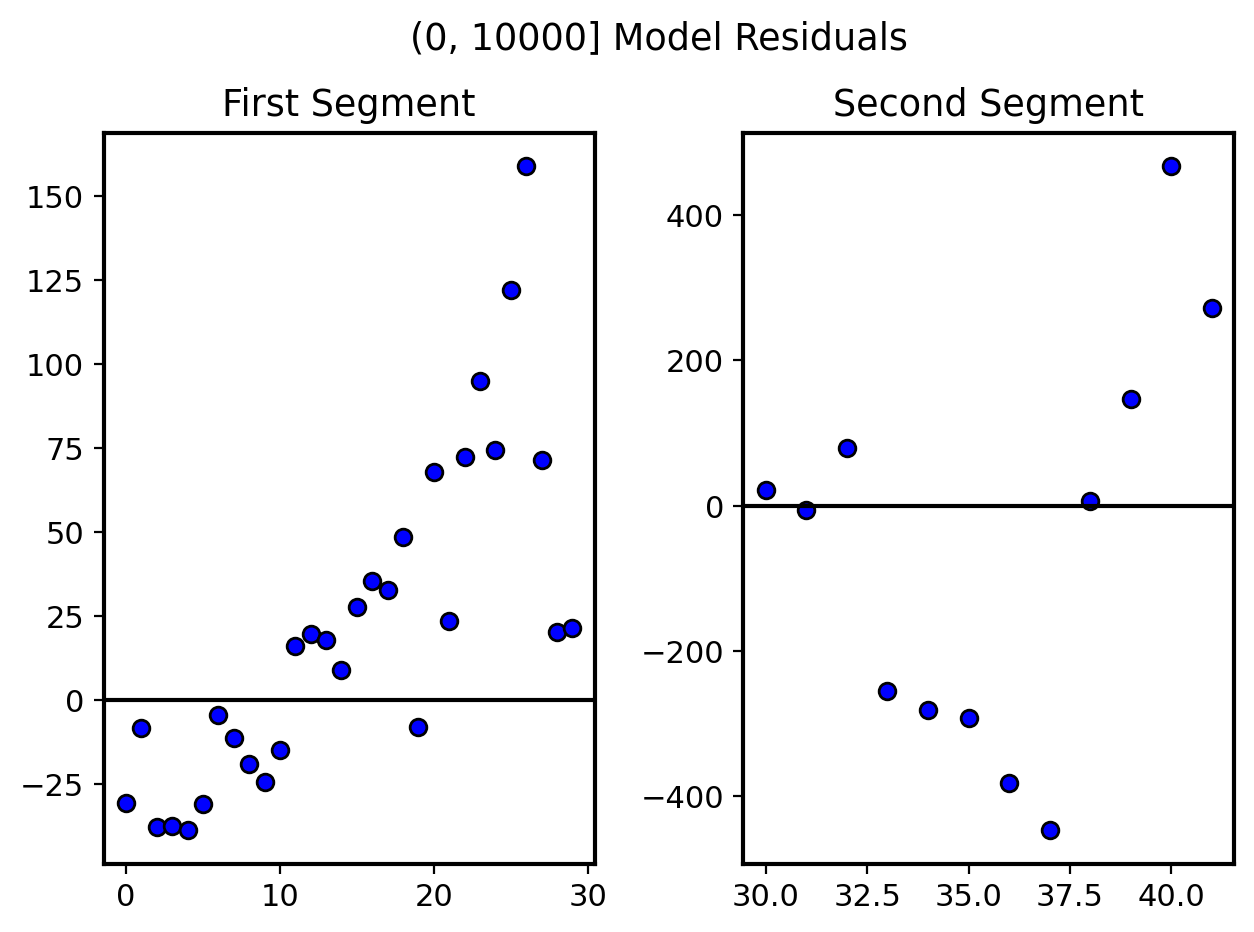

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 2545039.1269711494
Total Sum of Squares: 2663063.124758871
R^2: 0.955681111465051
------------------------------
b1: Estimate=18.7684009379927    Std. Err=88.01898180577176    p-value=0.8322573237082145
b2: Estimate=24.531696256217195    Std. Err=4.80420538001861    p-value=8.95036652494024e-06
b3: Estimate=271.9563464705025    Std. Err=17.472226501224817    p-value=2.5244201755064626e-18
a1: Estimate=296.48804272671975
breakpoint (estimate if not known): [29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=8.534137224568842e-49
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


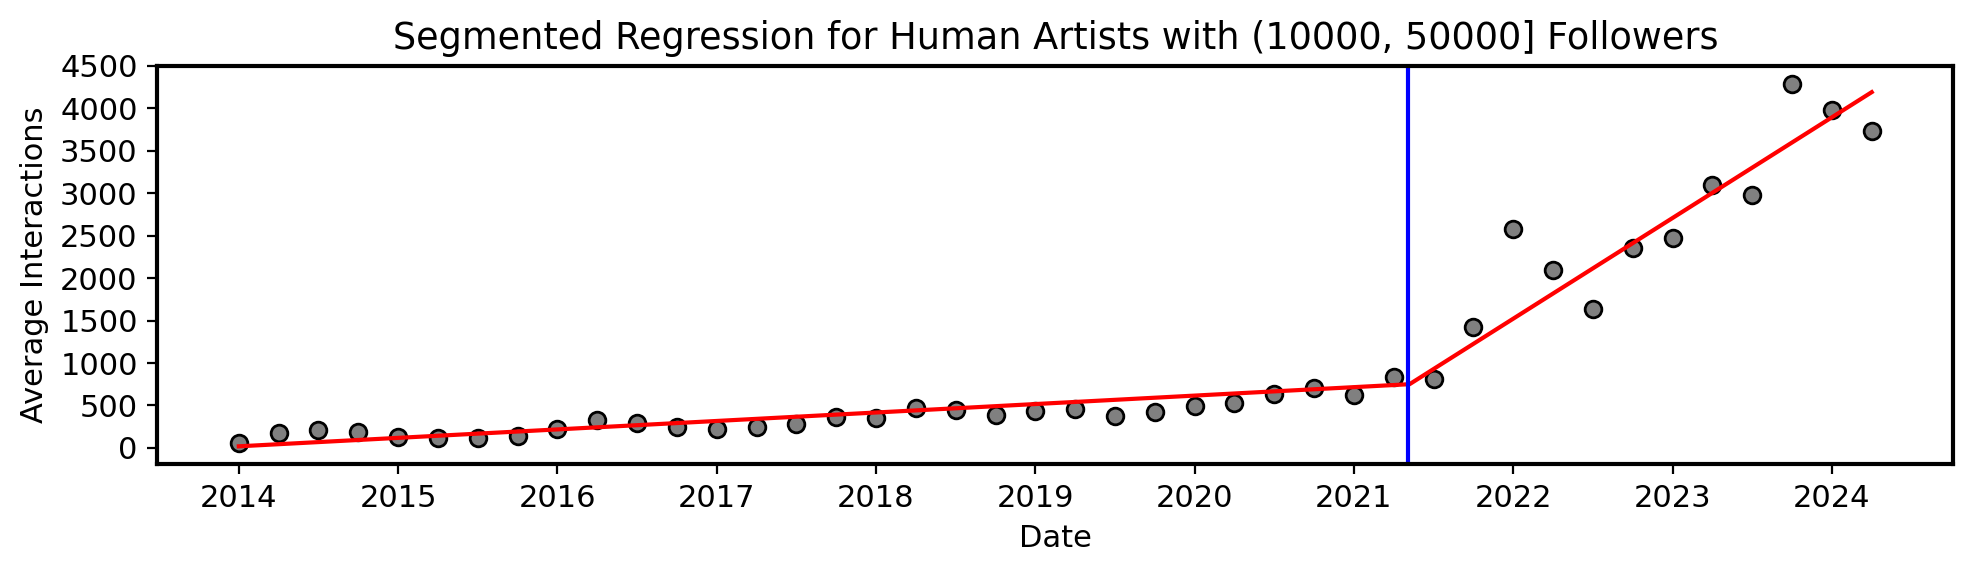

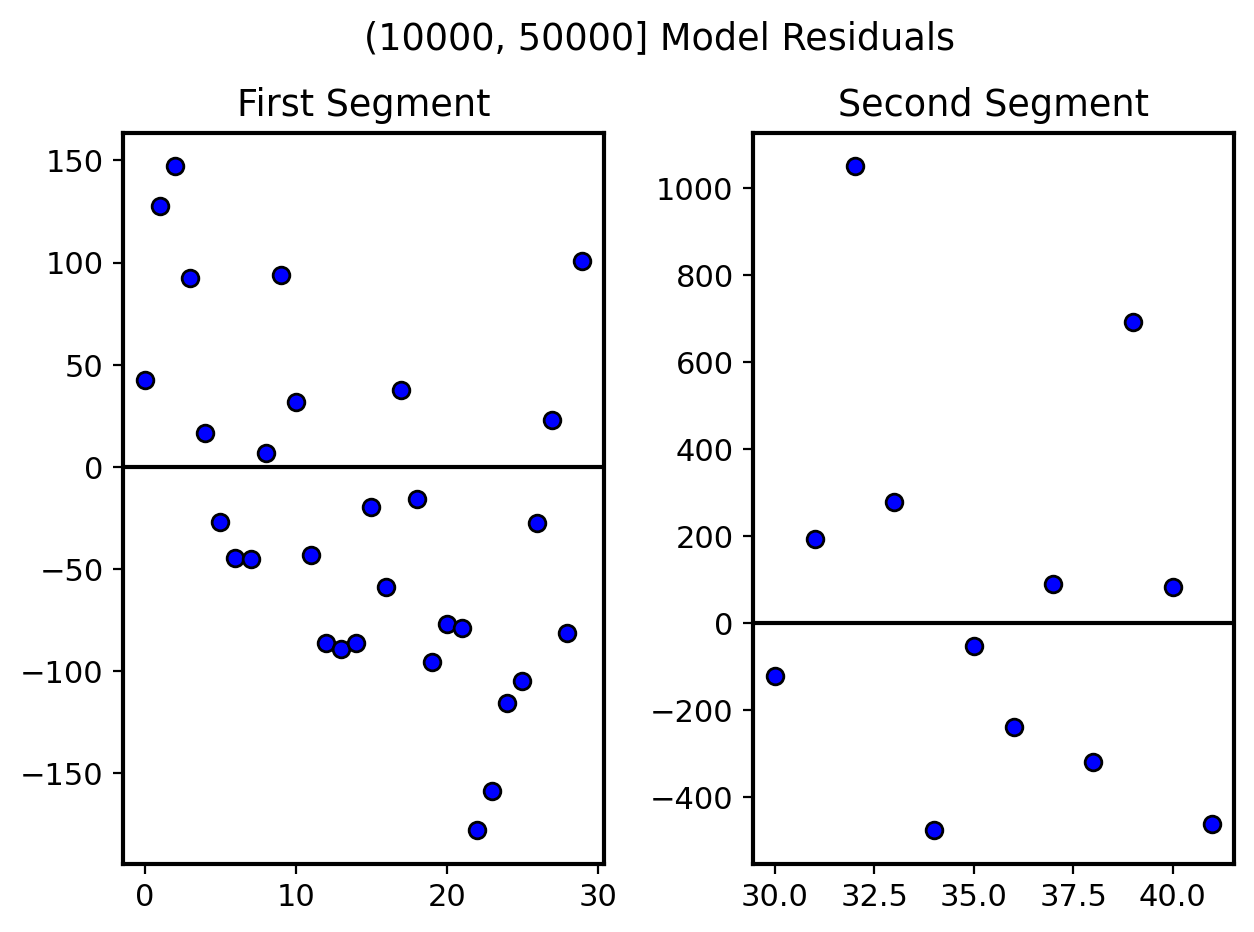

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 52167601.07922922
Total Sum of Squares: 66333504.65988381
R^2: 0.7864442161877565
------------------------------
b1: Estimate=-706.3075903989521    Std. Err=398.5011157867194    p-value=0.08413833702604784
b2: Estimate=143.4194528010124    Std. Err=21.75077653852656    p-value=7.776836048412001e-08
b3: Estimate=151.92804006238757    Std. Err=79.10454782788462    p-value=0.06211564876730805
a1: Estimate=295.34749286339996
breakpoint (estimate if not known): [29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=0.0466059028763882
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


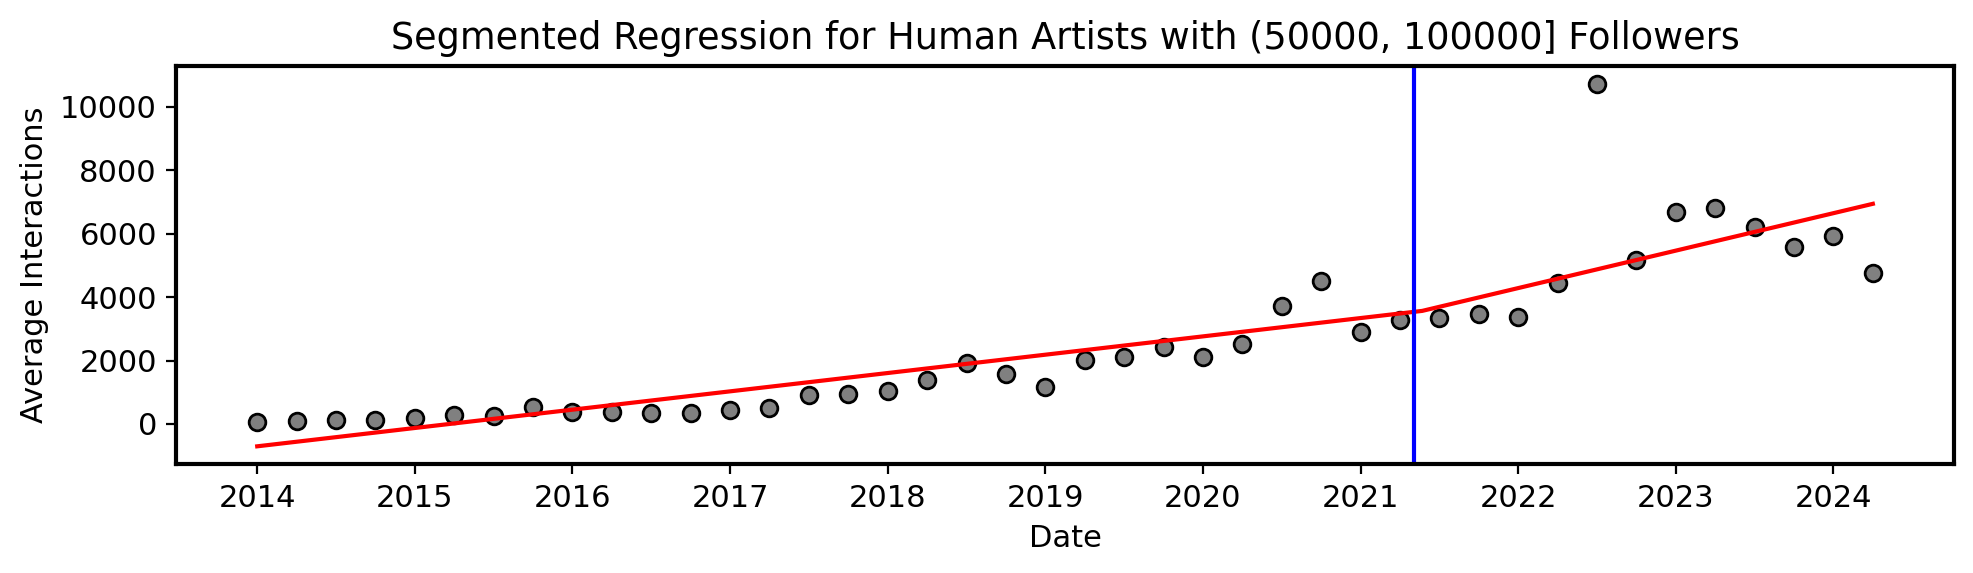

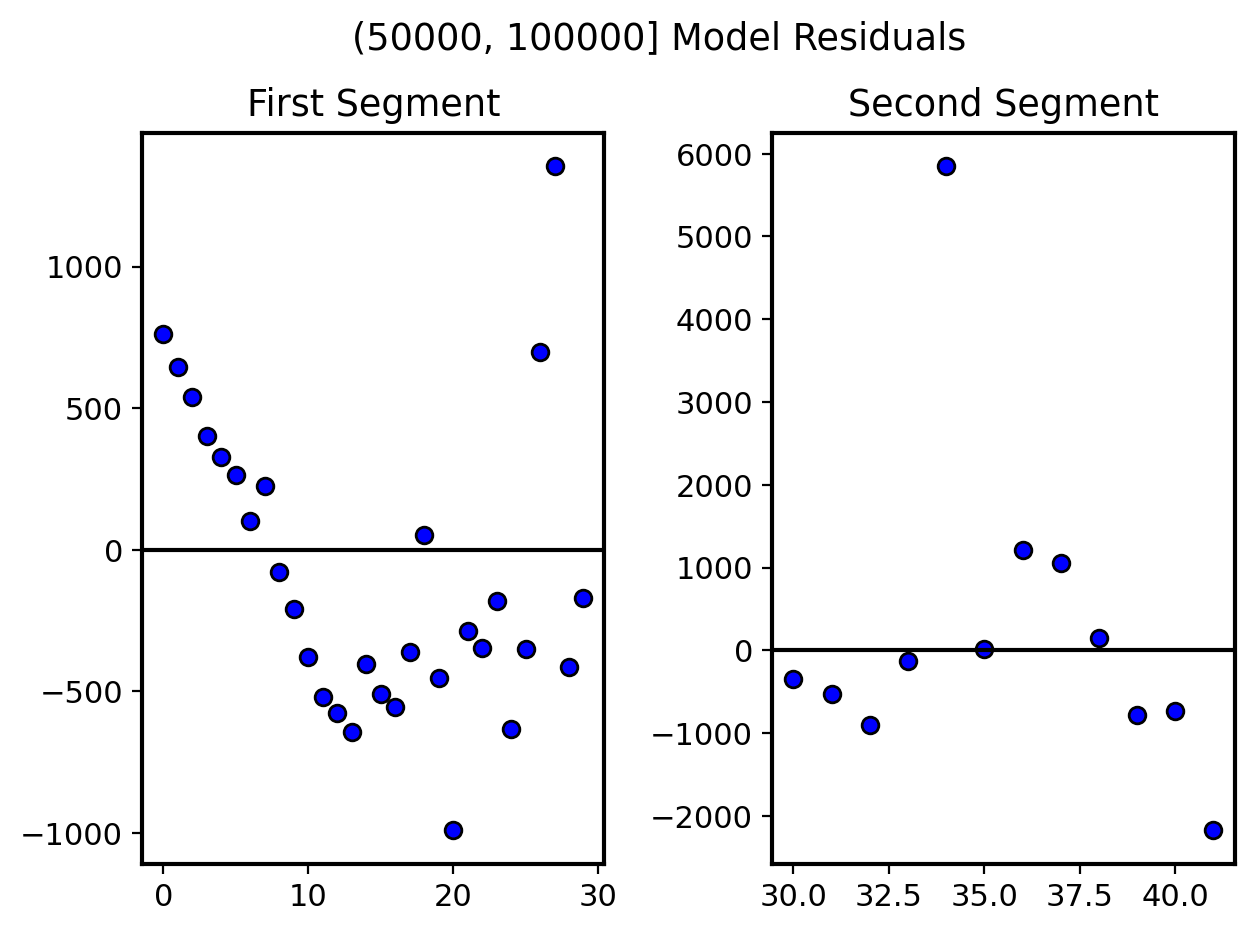

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 157264969.7589113
Total Sum of Squares: 177107336.56546912
R^2: 0.8879641736398485
------------------------------
b1: Estimate=-2652.2748571309585    Std. Err=691.9028293258613    p-value=0.0004492289499048841
b2: Estimate=469.96619002591825    Std. Err=37.765073247864244    p-value=3.709366654610659e-15
b3: Estimate=-103.44050658106714    Std. Err=137.3463167012802    p-value=0.4558905378855499
a1: Estimate=366.52568344485104
breakpoint (estimate if not known): [29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=0.009919041222723725
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


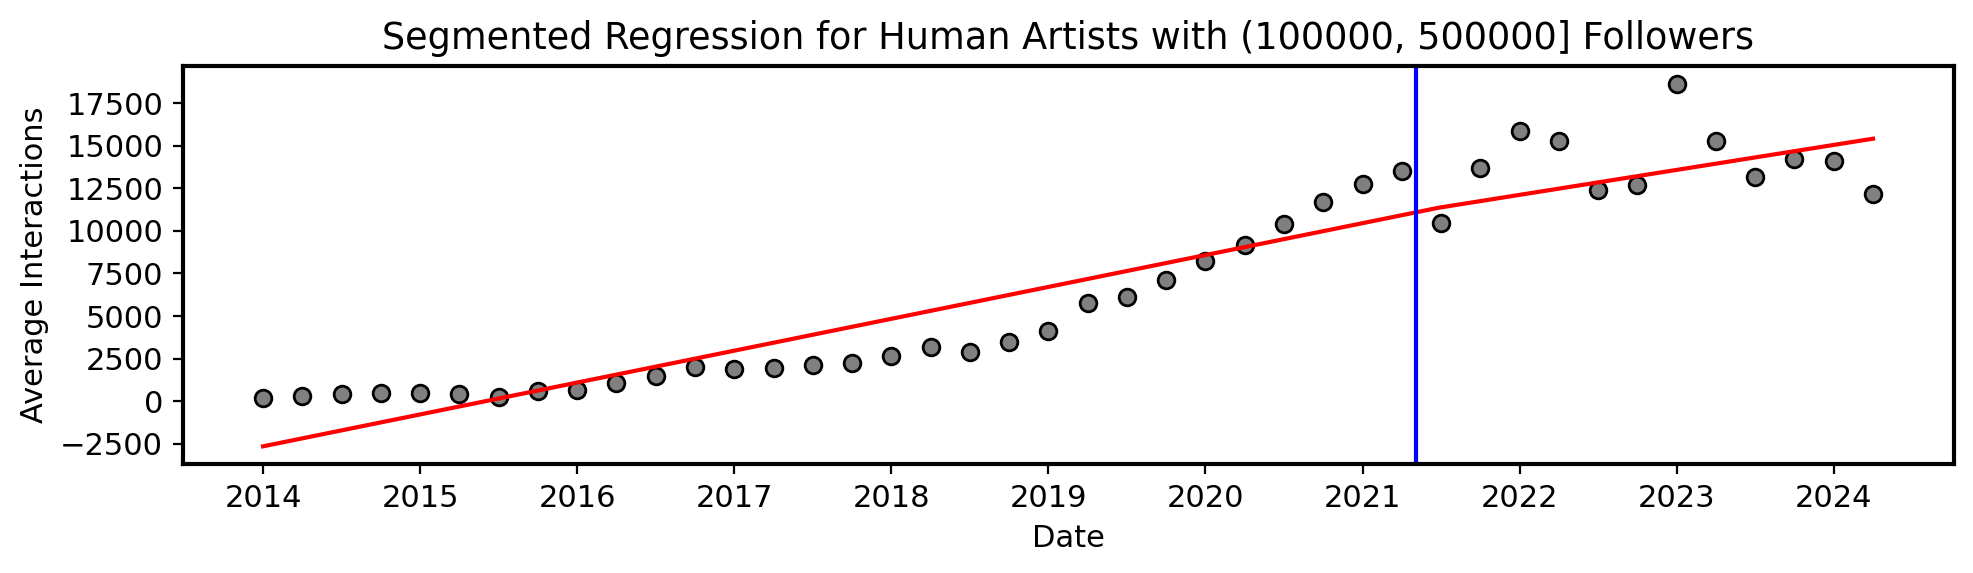

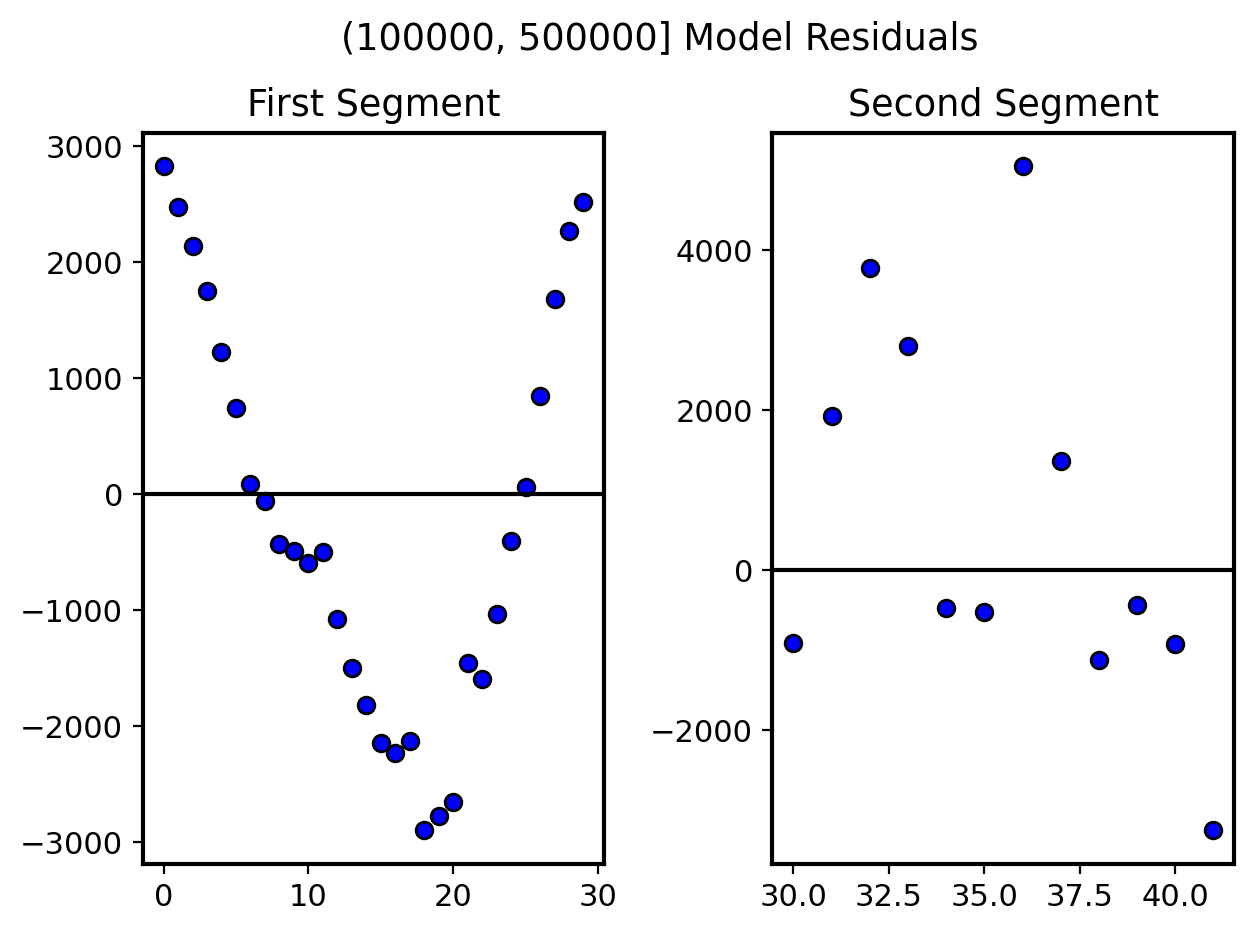

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 390767672.751773
Total Sum of Squares: 417971320.9327102
R^2: 0.9349150364665408
------------------------------
b1: Estimate=-3906.8031100445473    Std. Err=1090.6575820586168    p-value=0.0009335916361728361
b2: Estimate=1150.4026782688068    Std. Err=59.52969366365136    p-value=1.4129054385501814e-21
b3: Estimate=-1076.7523460200048    Std. Err=216.50121278449907    p-value=1.3619362803678364e-05
a1: Estimate=73.65033224880182
breakpoint (estimate if not known): [29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=3.435733779179842e-09
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


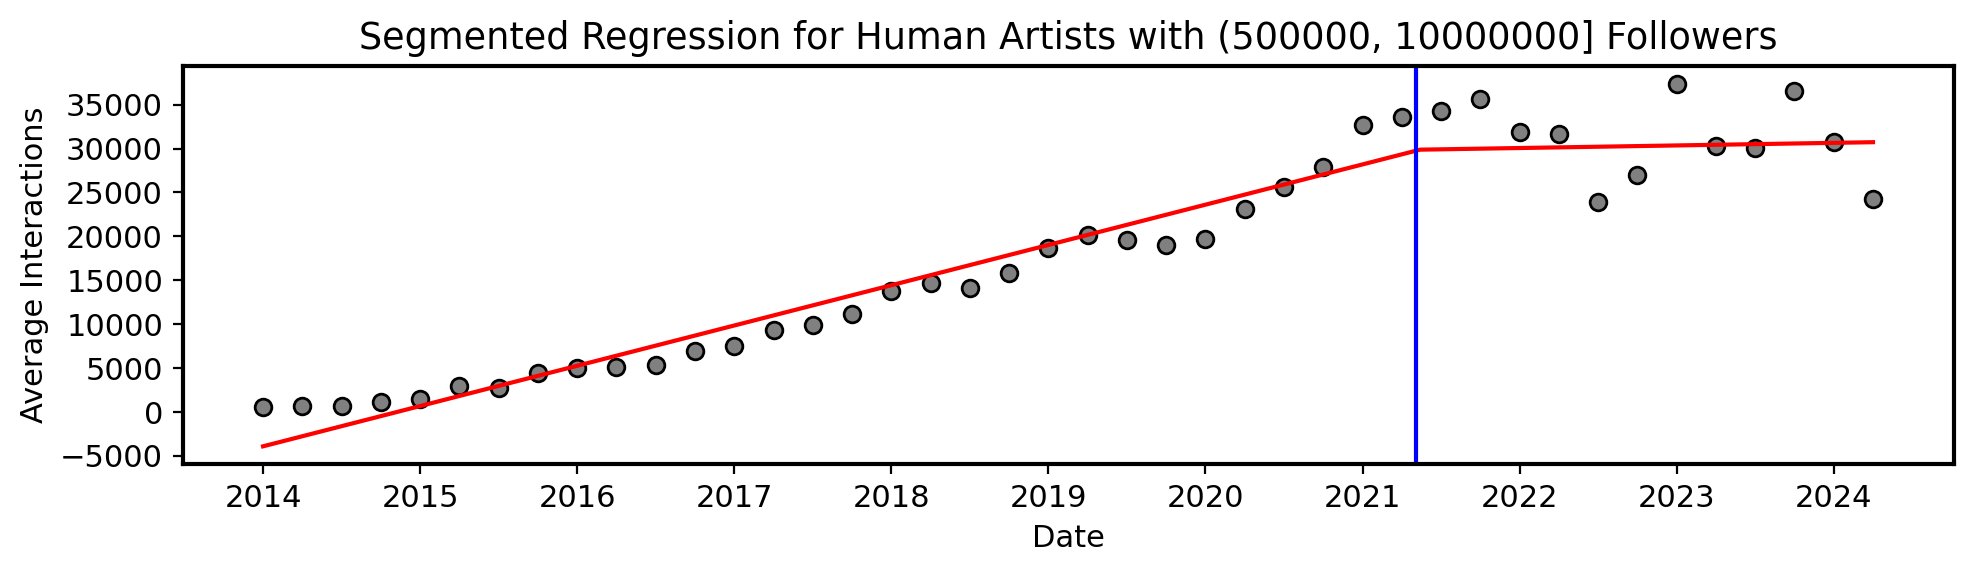

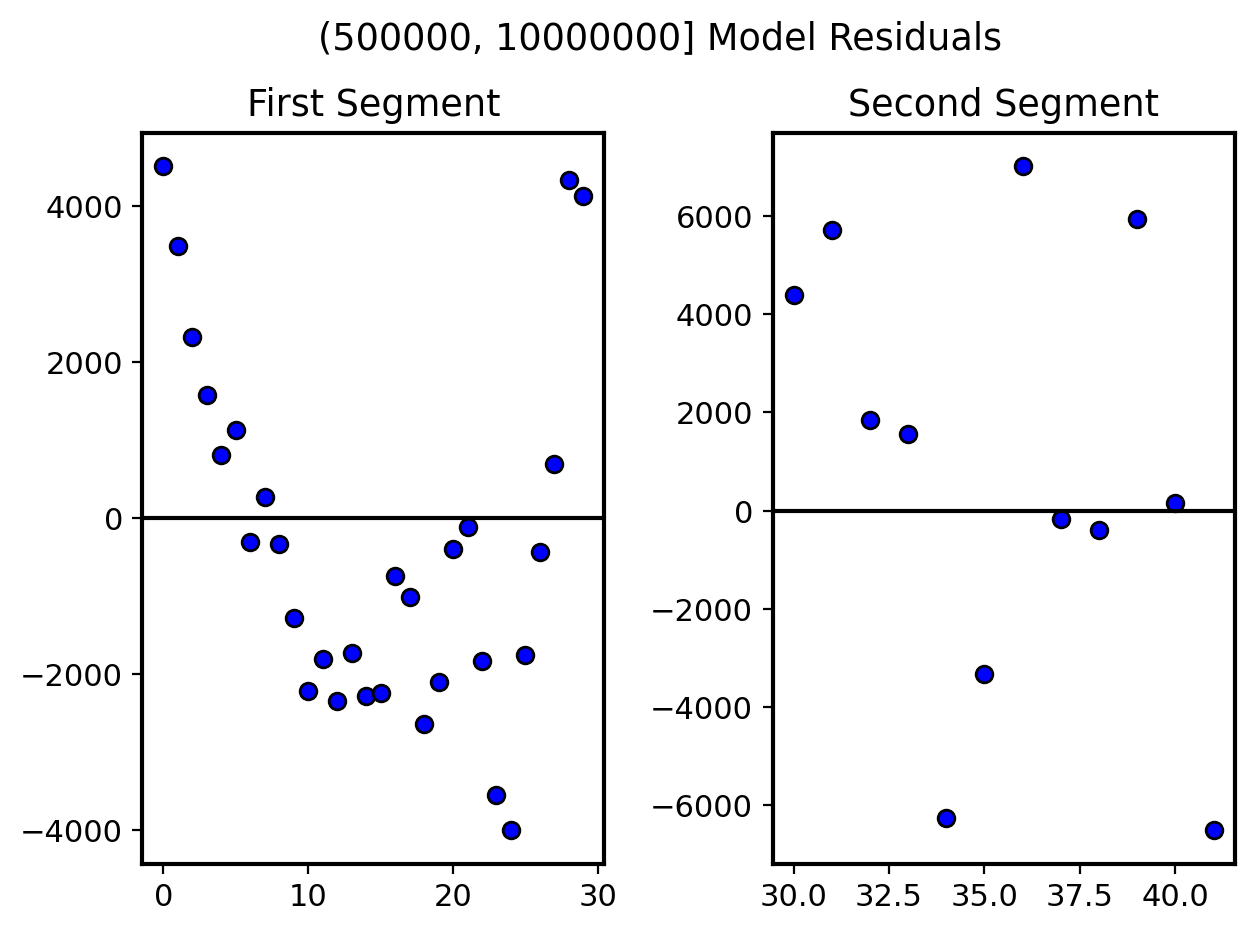

In [23]:
for col in pivot_df.columns:
    srwbp(pivot_df[col], title=col)
    

In [24]:
np.insert(aisr.fit_breaks, 1, 15)

array([ 0.       , 15.       , 29.3564189, 41.       ])

In [25]:
def srwbp2(y, fs= (10, 3), title="Segmented Regression"):
    fig, ax = plt.subplots(figsize=fs)
    # initialize piecewise linear fit with your x and y data
    x = np.arange(len(y))
    fbs = np.insert(aisr.fit_breaks, 1, 16)
    hsr = pwlf.PiecewiseLinFit(x, np.array(y), disp_res= True)
    res = hsr.fit_with_breaks(fbs)
    summary(hsr)
    # predict for the determined points
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = hsr.predict(xHat)

    ax.plot(x, np.array(y), 'o', color= "grey", markeredgecolor= "black")
    ax.plot(xHat, yHat, '-', color= 'red')
    ax.set_xticks(f2.index, minor=False, labels=pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)
    ax.axvline(hsr.fit_breaks[1], color= "blue")
    ax.axvline(hsr.fit_breaks[2], color= "blue")
    # ax.set_title(f"Segmented Regressions for {title} Interactions")
    ax.set_title(f"Segmented Regression for Human Artists with {title} Followers")

    ax.set_ylabel("Average Interactions")
    ax.set_xlabel("Date")
    plt.locator_params(nbins=11)
    plt.tight_layout()
    plt.show()

    xHat = np.linspace(min(x), max(x), num=len(x))
    x = list(x)
    plt.figure().set_figwidth(10)
    yHat = hsr.predict(xHat)
    ax= plt.subplot(1, 3, 1)
    fbs = np.floor(fbs)
    
    ax.plot(x[x.index(fbs[0]): x.index(fbs[1]) + 1], (y - yHat)[x.index(fbs[0]): x.index(fbs[1]) + 1], "bo", markeredgecolor= "black")
    ax.axhline(0, color= "black")
    plt.title('First Segment')

    ax= plt.subplot(1, 3, 2)
    ax.plot(x[x.index(fbs[1]): x.index(fbs[2]) + 1], (y - yHat)[x.index(fbs[1]): x.index(fbs[2]) + 1], "bo", markeredgecolor= "black")
    ax.axhline(0, color= "black")
    plt.title('Second Segment')
    
    ax = plt.subplot(1, 3, 3)
    
    ax.plot(x[-12:], (y - yHat)[-12:], "bo", markeredgecolor= "black")
    ax.axhline(0, color= "black")
    plt.title('Third Segment')

    plt.suptitle(f'{title} Model Residuals', x= 0.525, y= 0.965)

    
    plt.tight_layout()
    plt.show()

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 2
Sum of Squares: 46155652.518106624
Total Sum of Squares: 56908164.8065537
R^2: 0.8110550160069687
------------------------------
b1: Estimate=-19.657117083827732    Std. Err=489.34318399492474    p-value=0.9681675832642507
b2: Estimate=53.141641011726946    Std. Err=45.56523153937119    p-value=0.2507705326626074
b3: Estimate=187.8995084872844    Std. Err=84.45758623161247    p-value=0.03210999425437391
b4: Estimate=-13.25065069557749    Std. Err=105.80360834279044    p-value=0.9009952240857042
a1: Estimate=227.79049880343388
breakpoint (estimate if not known): [16.        29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=0.0466059028763882
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


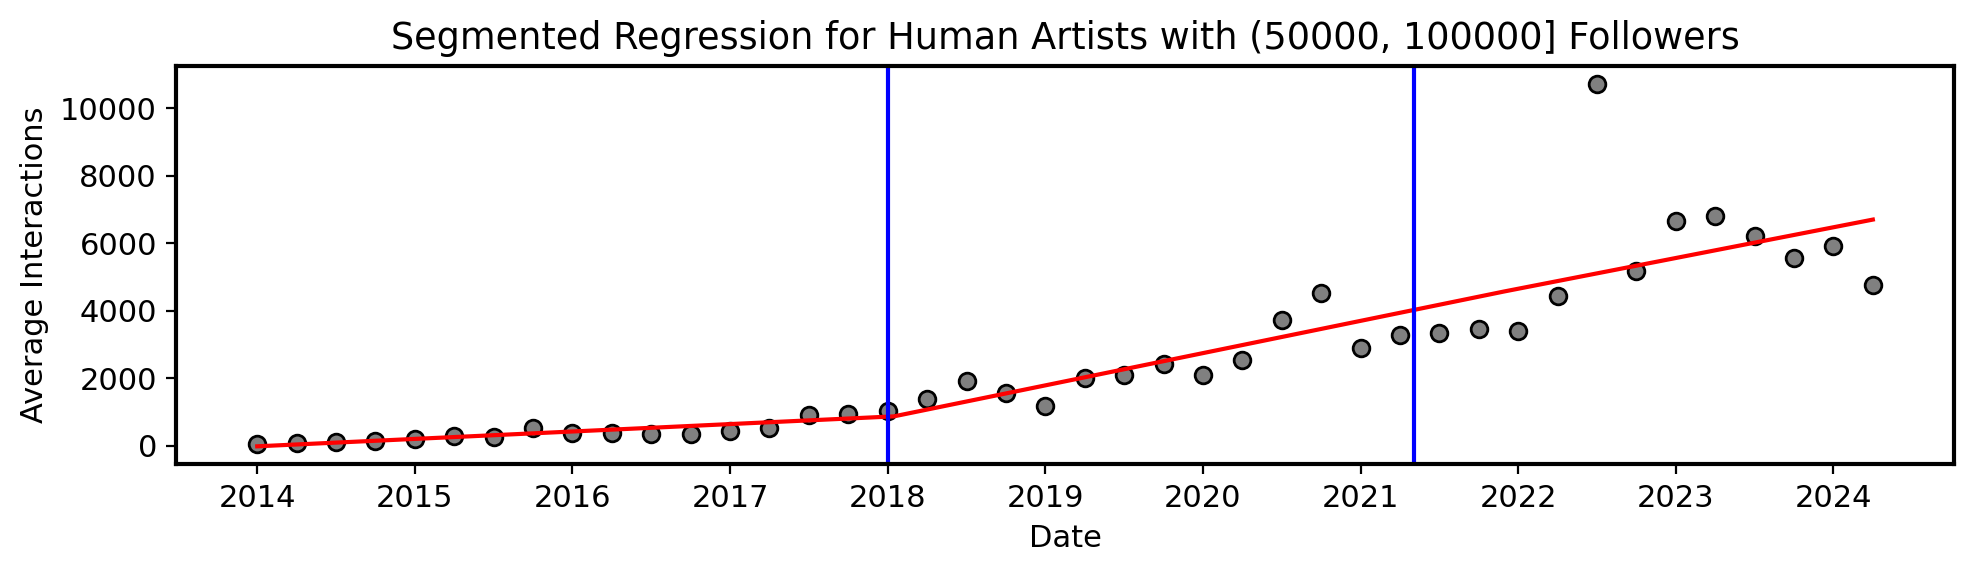

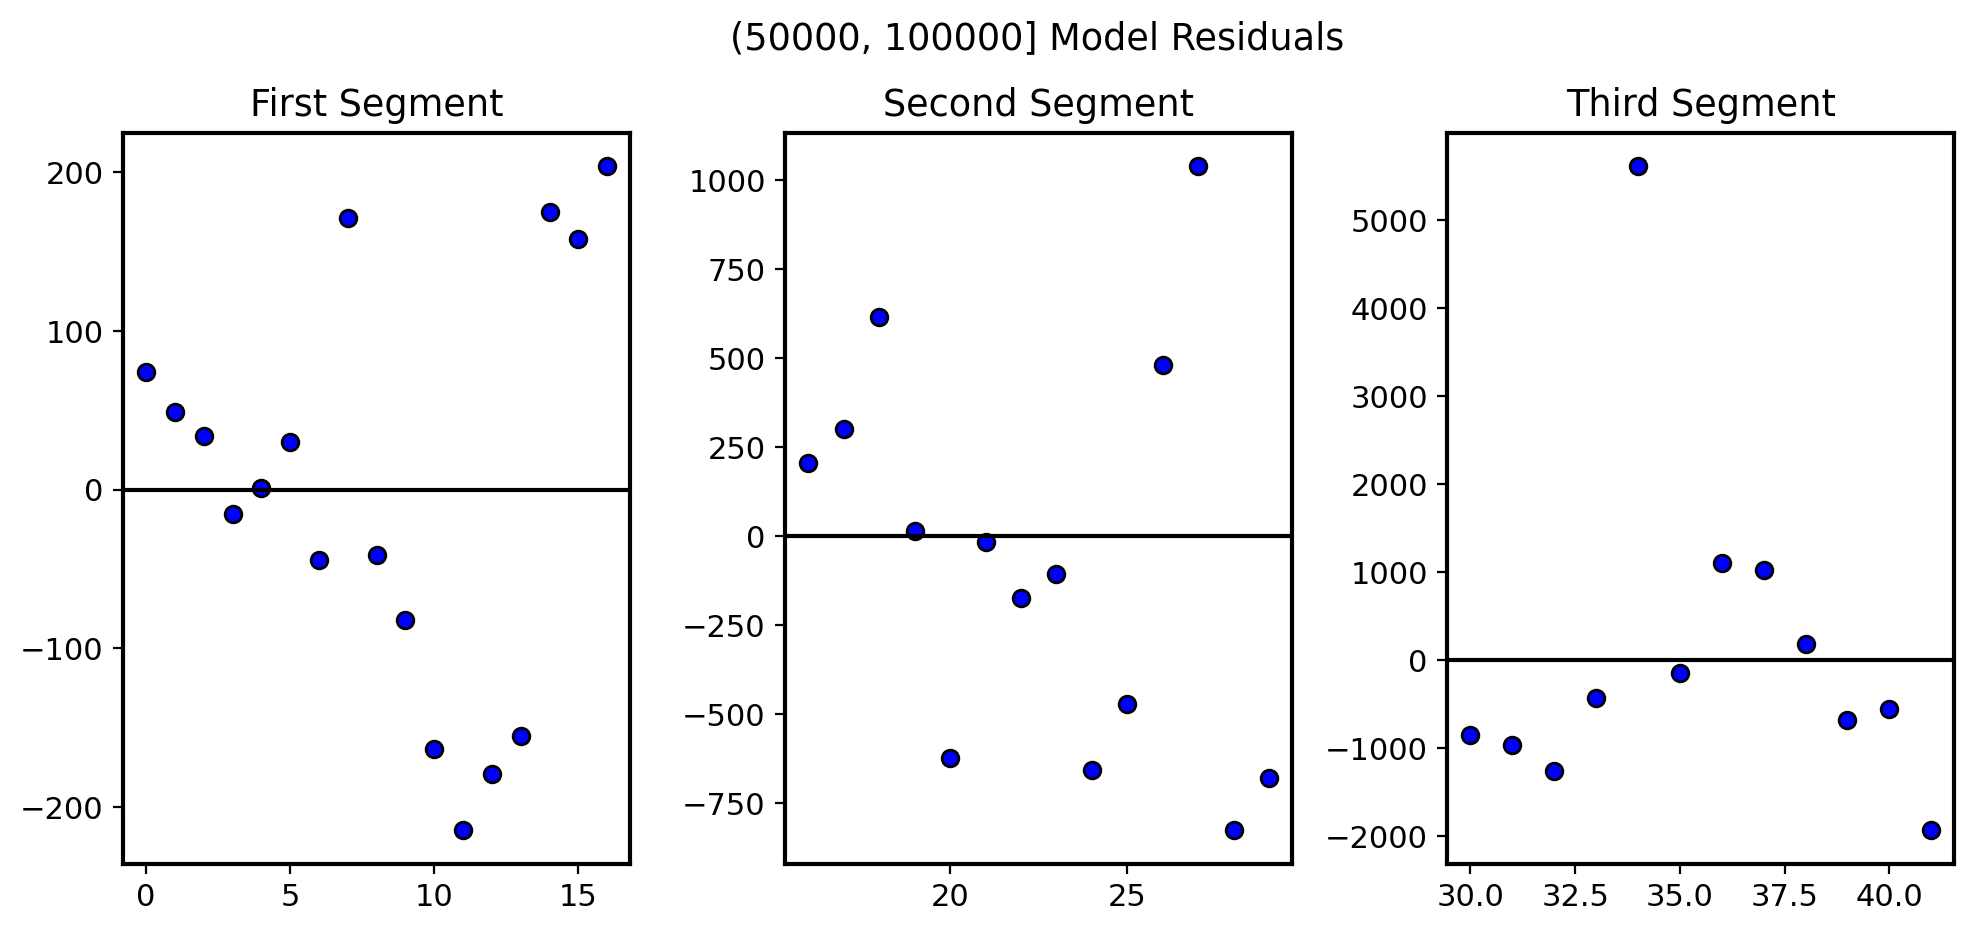

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 2
Sum of Squares: 57706938.8452272
Total Sum of Squares: 60181011.48142919
R^2: 0.958889480663424
------------------------------
b1: Estimate=141.98148252631495    Std. Err=547.1609746050647    p-value=0.7966597480076382
b2: Estimate=102.58954393595349    Std. Err=50.9489399518158    p-value=0.051175724099222795
b3: Estimate=764.6385070911103    Std. Err=94.43657683757512    p-value=8.505561842941281e-10
b4: Estimate=-775.6188881066457    Std. Err=118.30471405559456    p-value=9.863815400228835e-08
a1: Estimate=91.6091629204182
breakpoint (estimate if not known): [16.        29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=0.009919041222723725
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


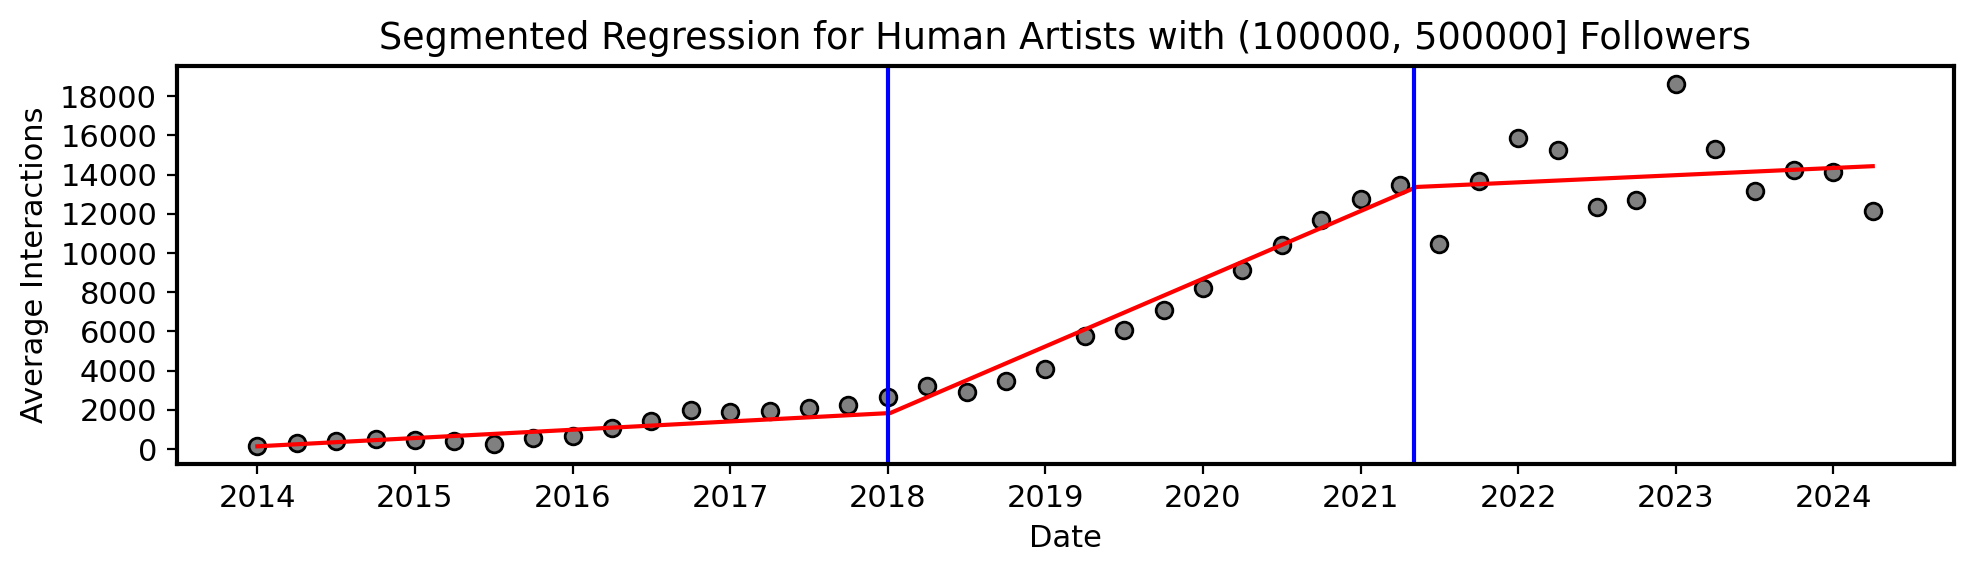

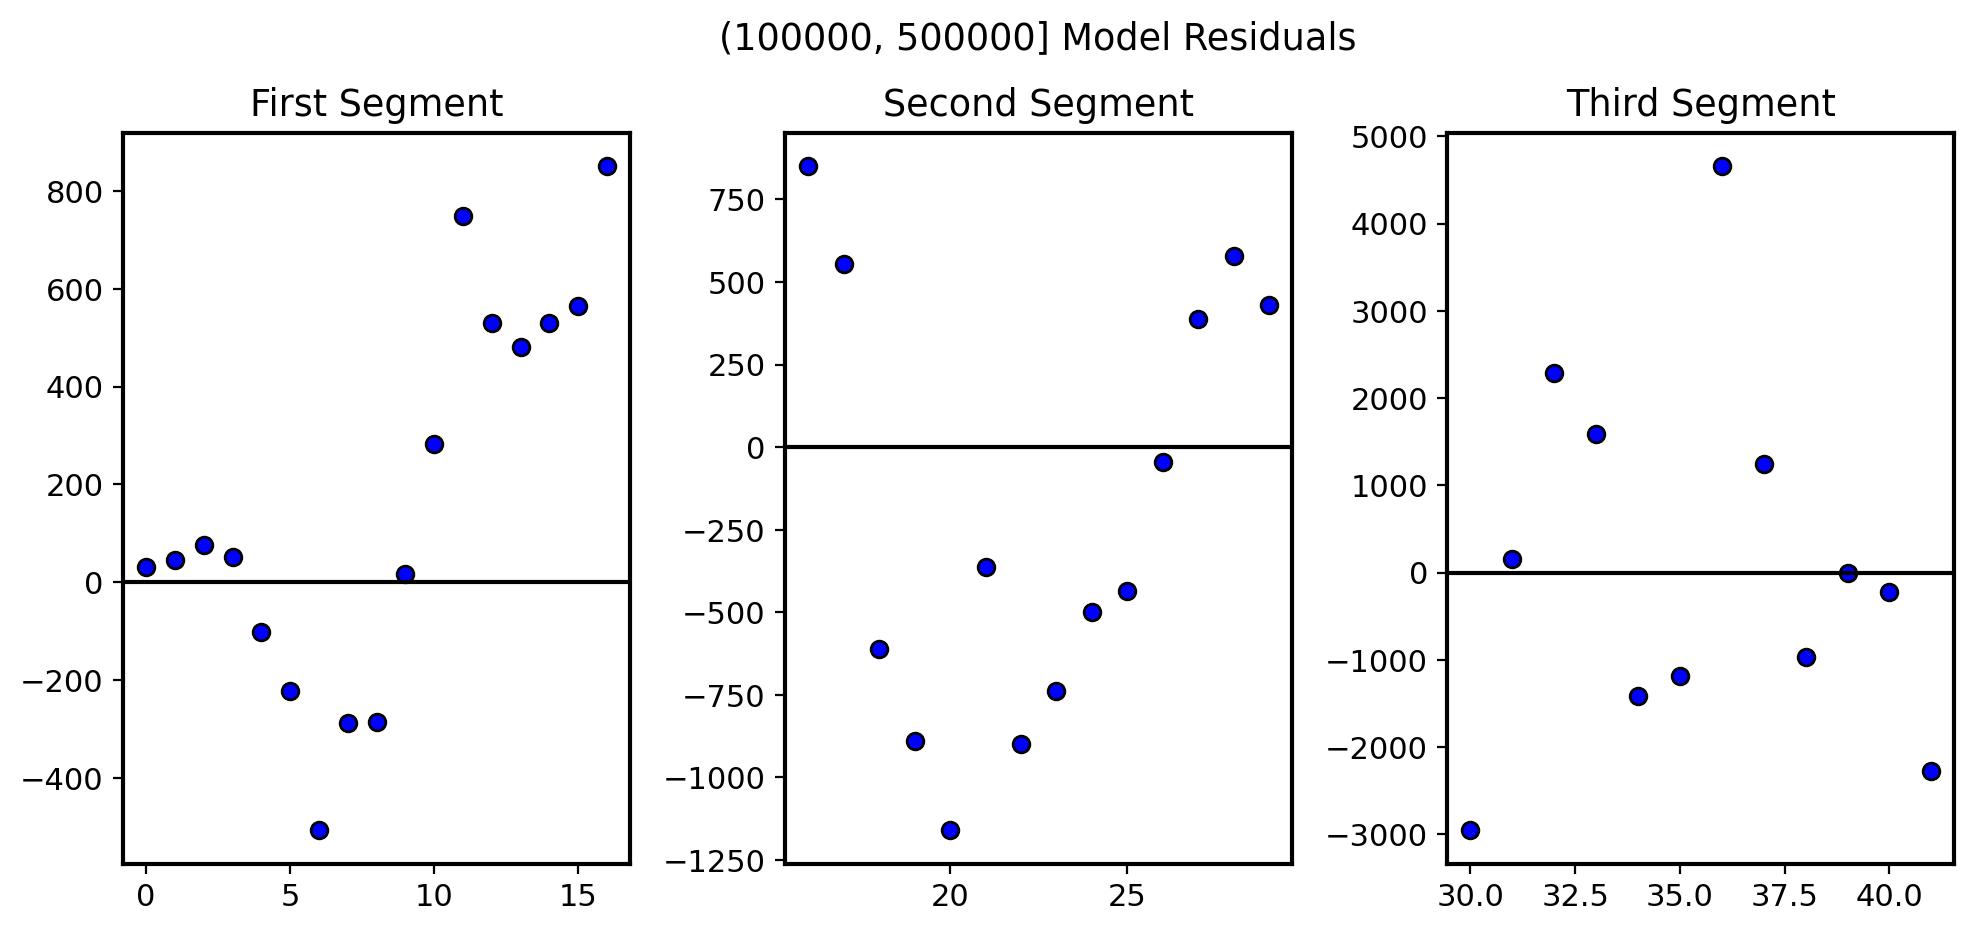

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 2
Sum of Squares: 270338061.8673082
Total Sum of Squares: 283084391.8675505
R^2: 0.9549733917996932
------------------------------
b1: Estimate=-833.5754219520292    Std. Err=1184.2808148624317    p-value=0.4858070370329105
b2: Estimate=746.3480950516046    Std. Err=110.27440720907548    p-value=5.0735196307618173e-08
b3: Estimate=840.9780441483572    Std. Err=204.3994936787052    p-value=0.0002008227103612209
b4: Estimate=-1816.0392840591223    Std. Err=256.0599342176287    p-value=1.8457227180974096e-08
a1: Estimate=-228.71314485916062
breakpoint (estimate if not known): [16.        29.3564189] = 2021-07
-------------------------------
Davies test for existence of at least 1 breakpoint: p=3.435733779179842e-09
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


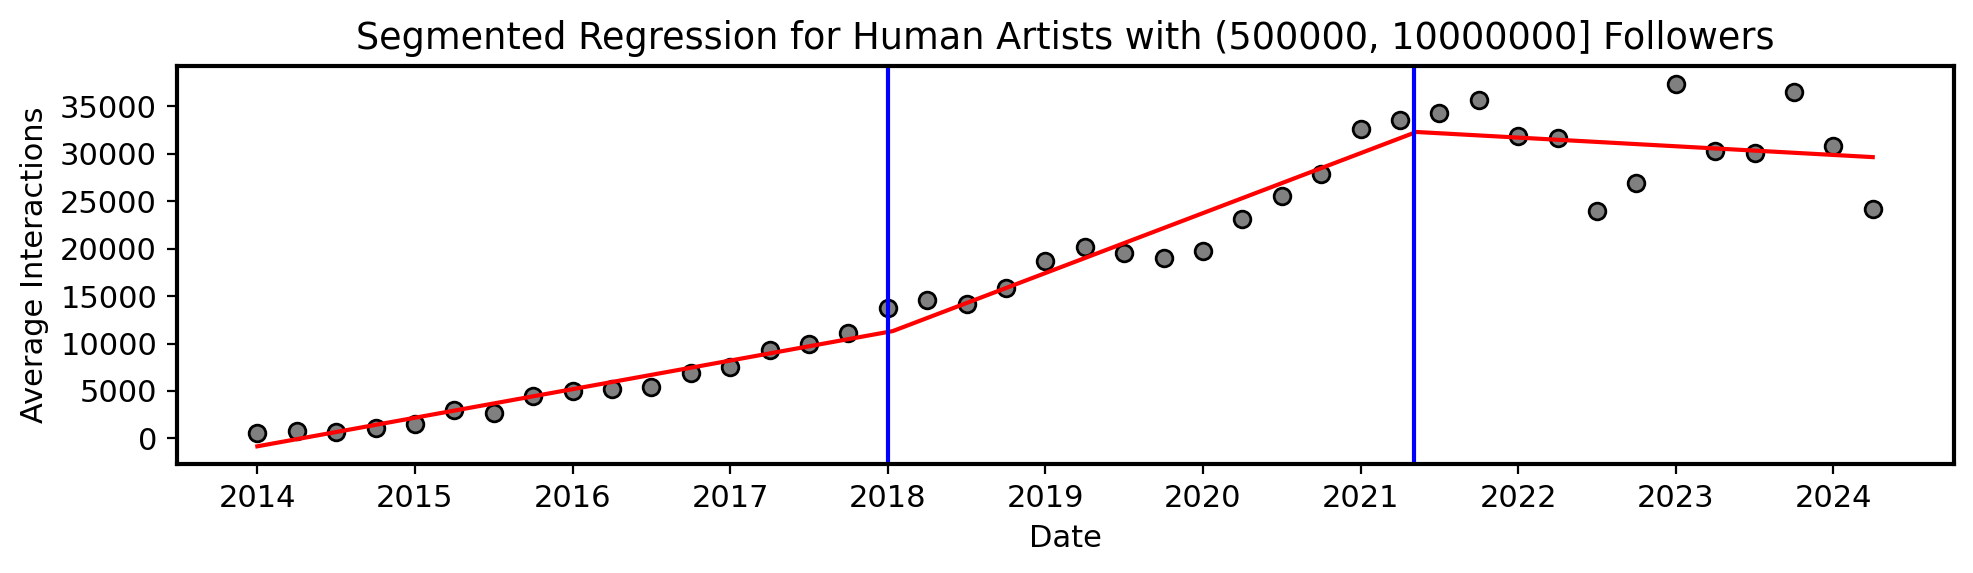

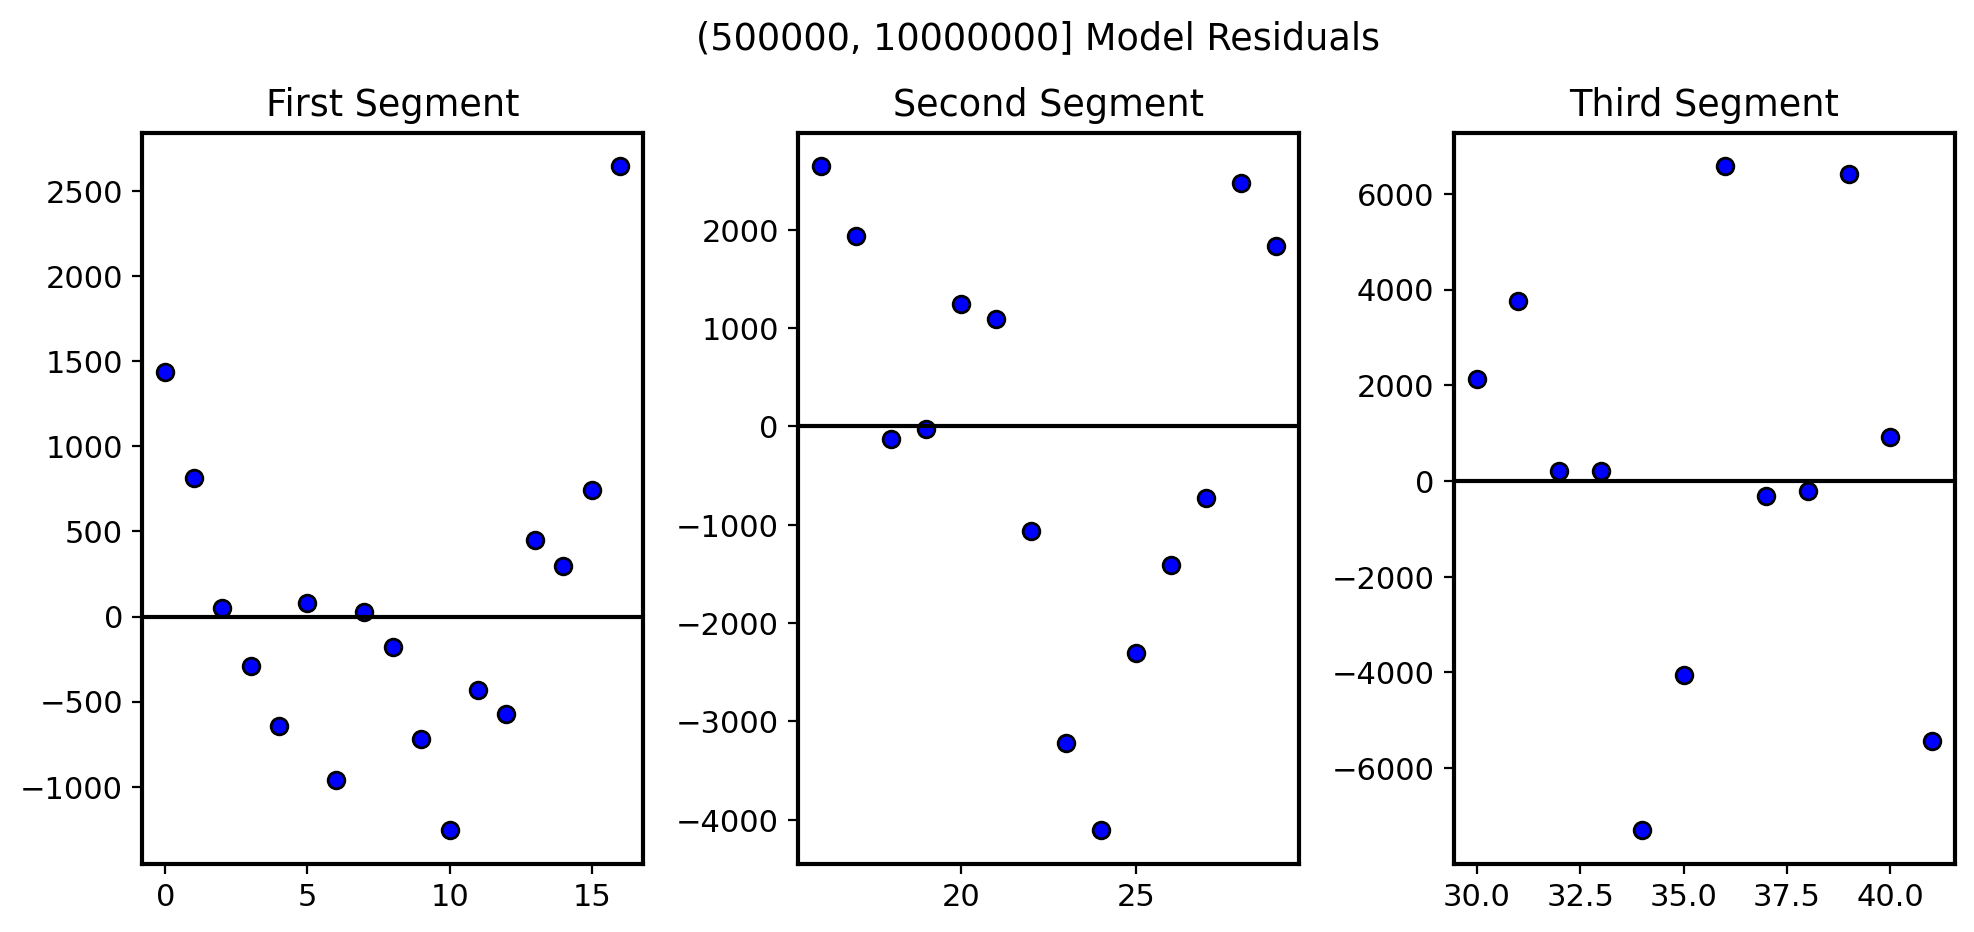

In [26]:
for col in pivot_df.columns[2:]:
    srwbp2(pivot_df[col], fs=(10,3), title=col)

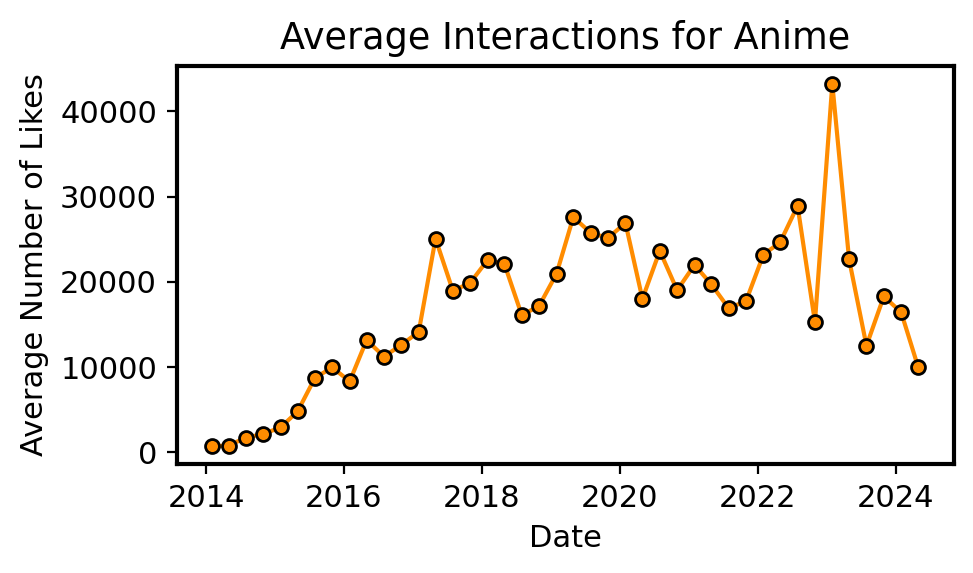

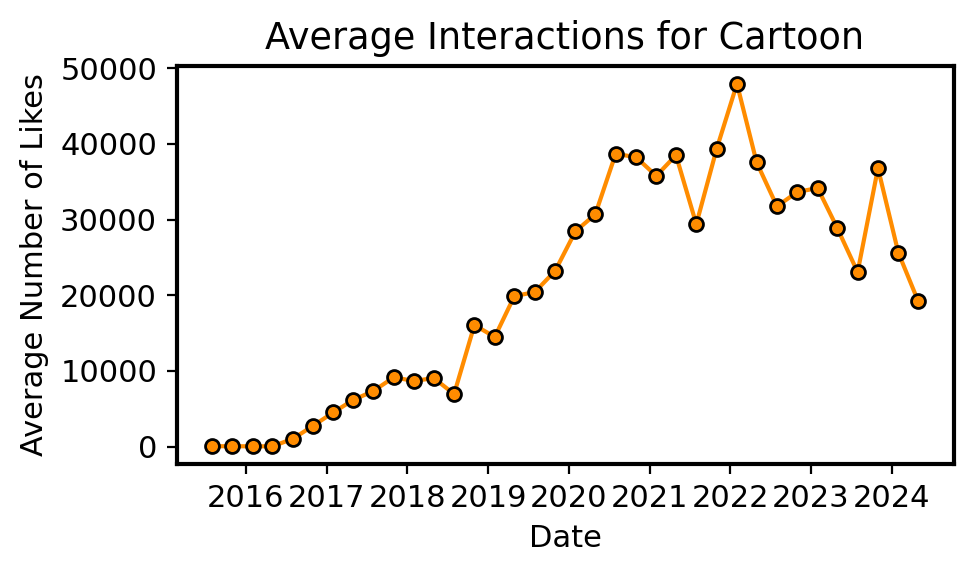

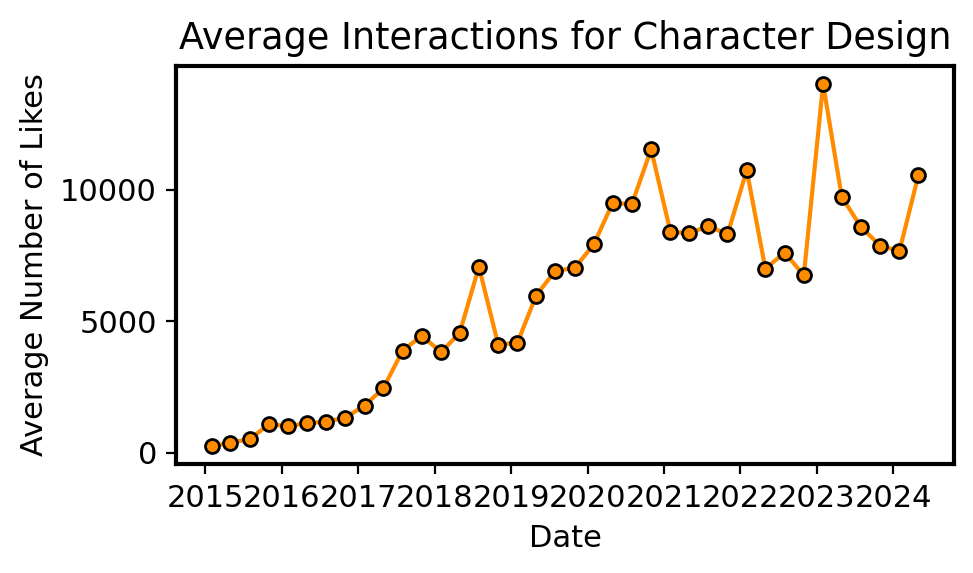

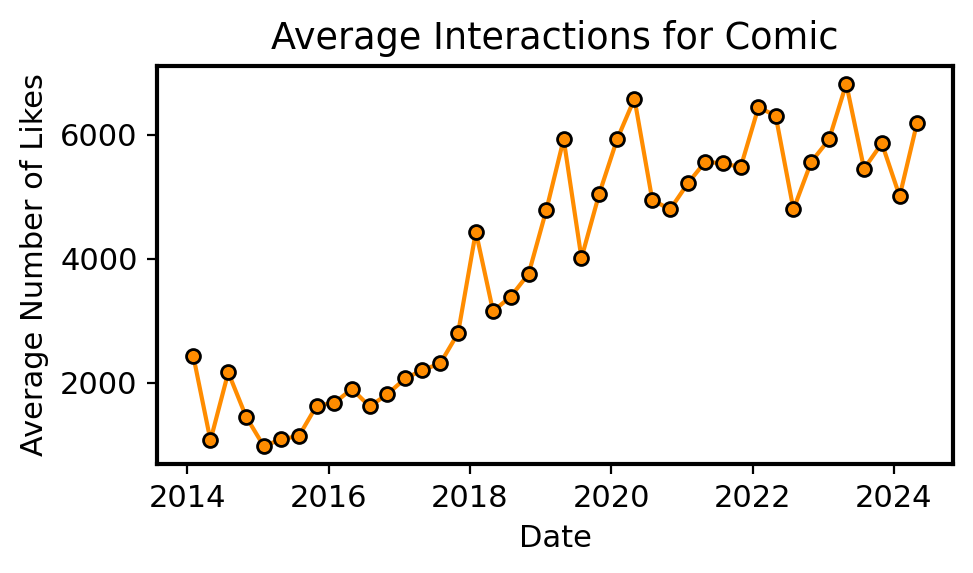

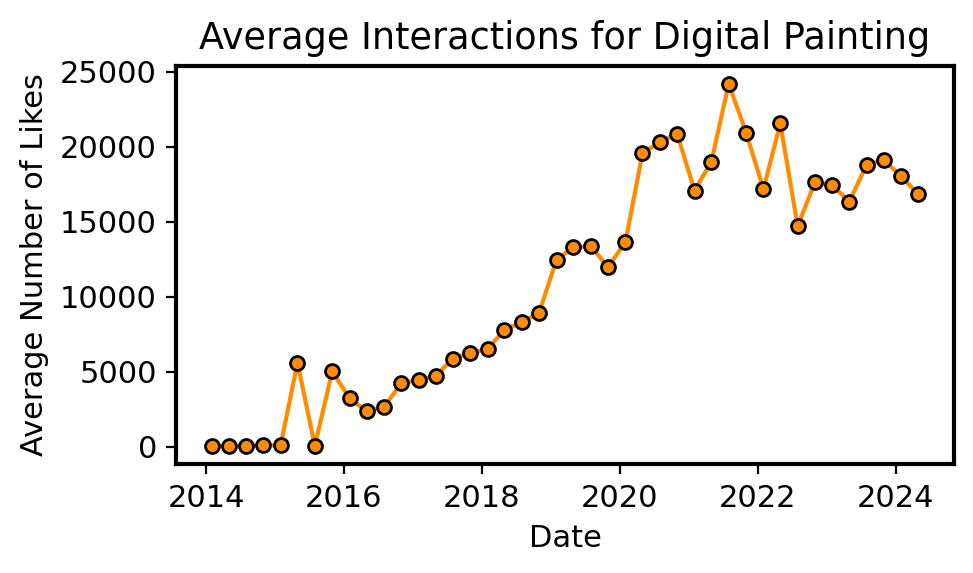

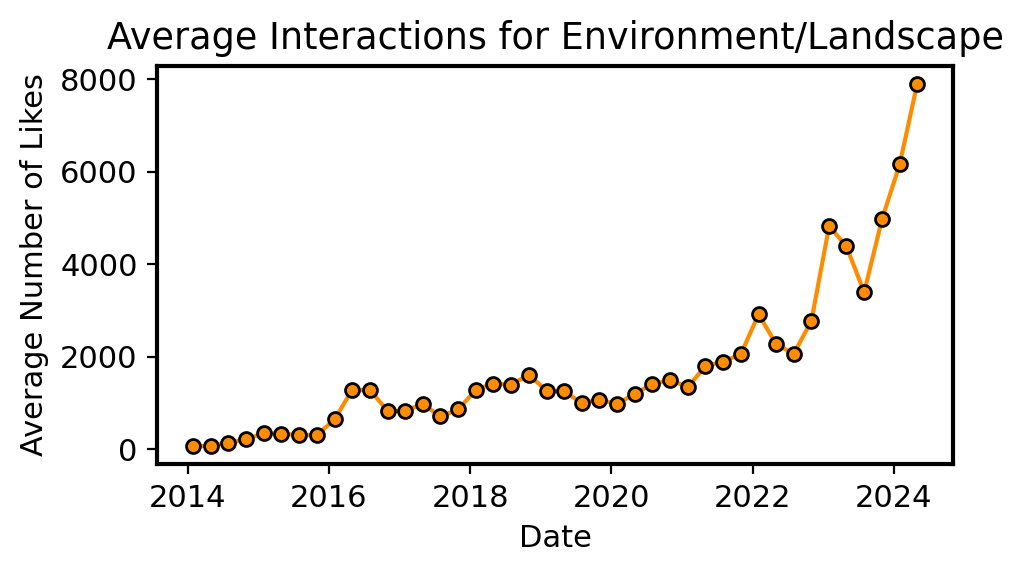

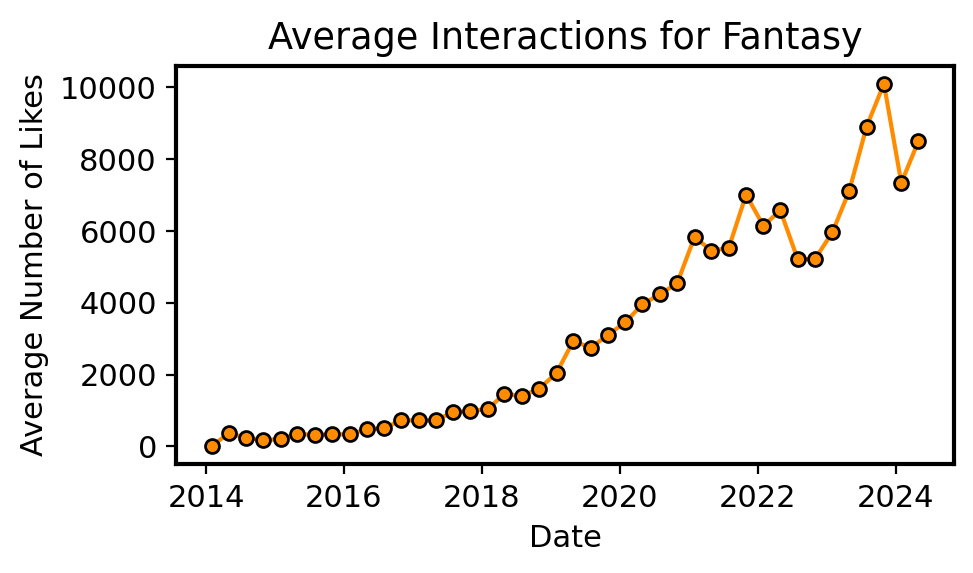

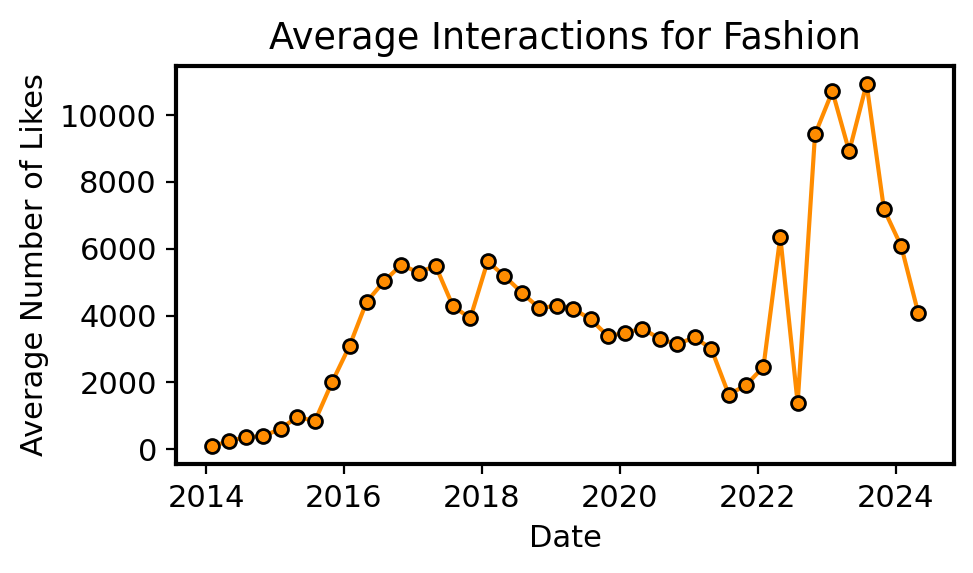

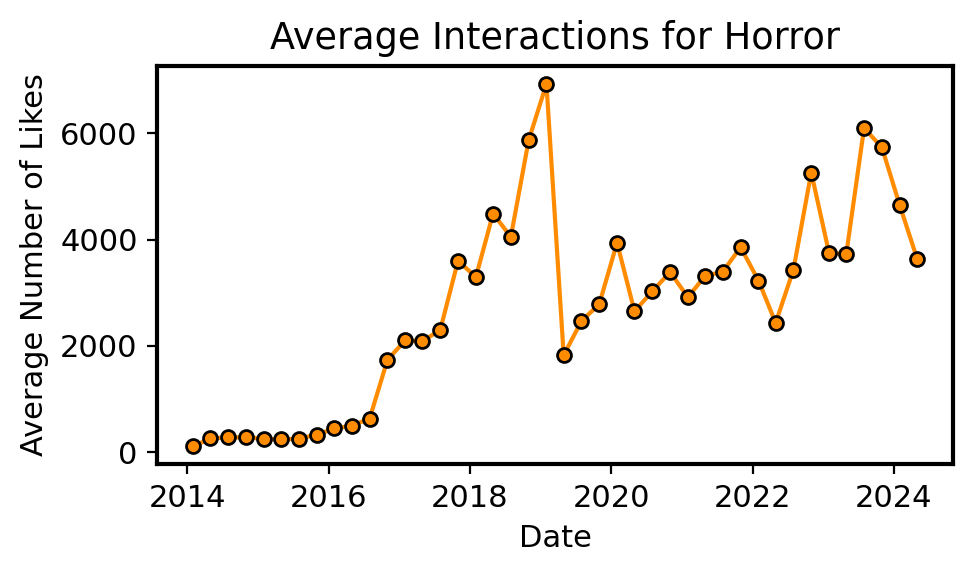

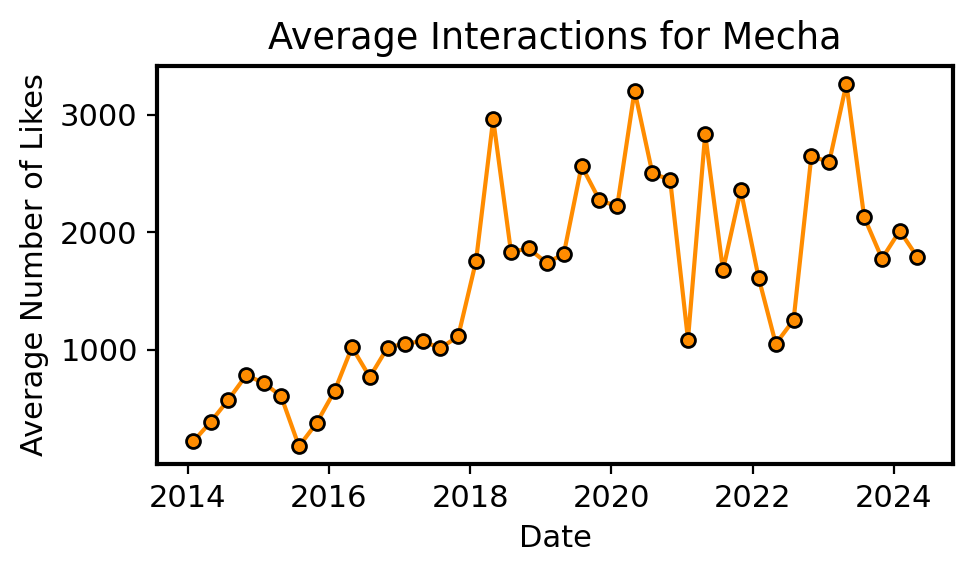

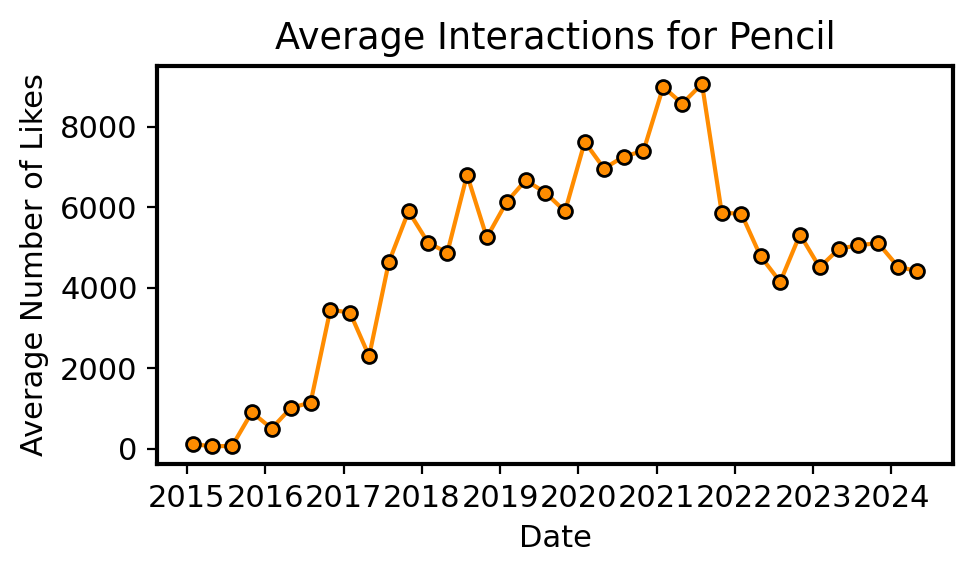

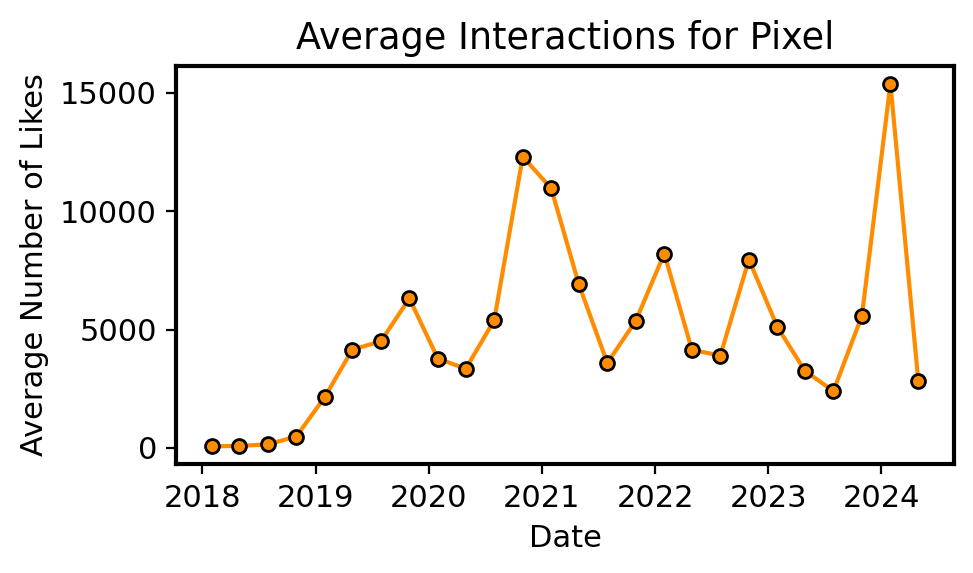

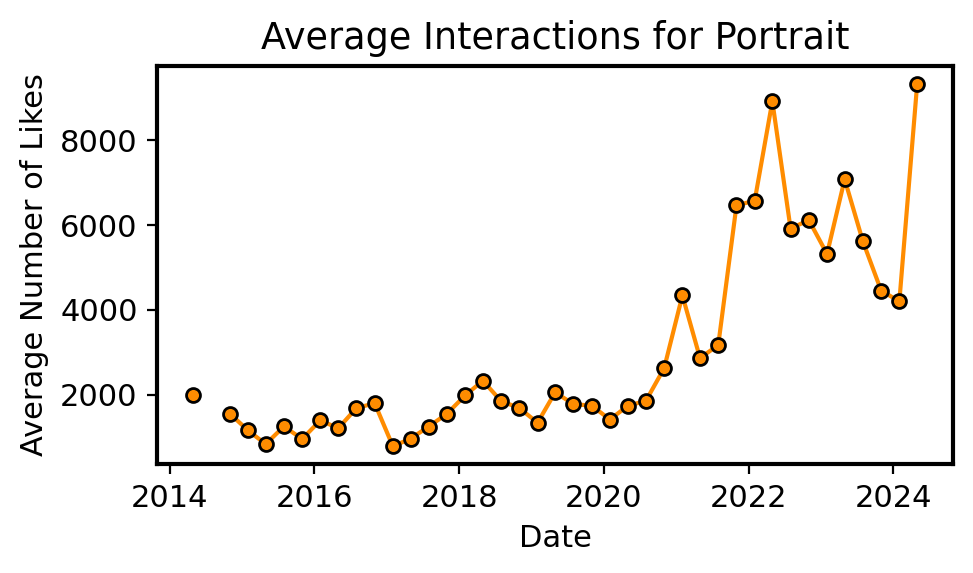

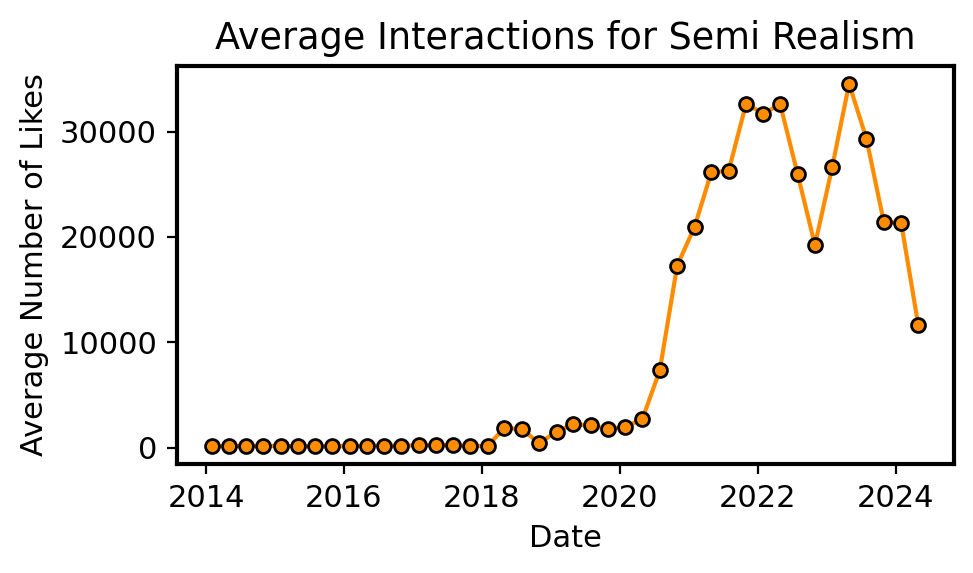

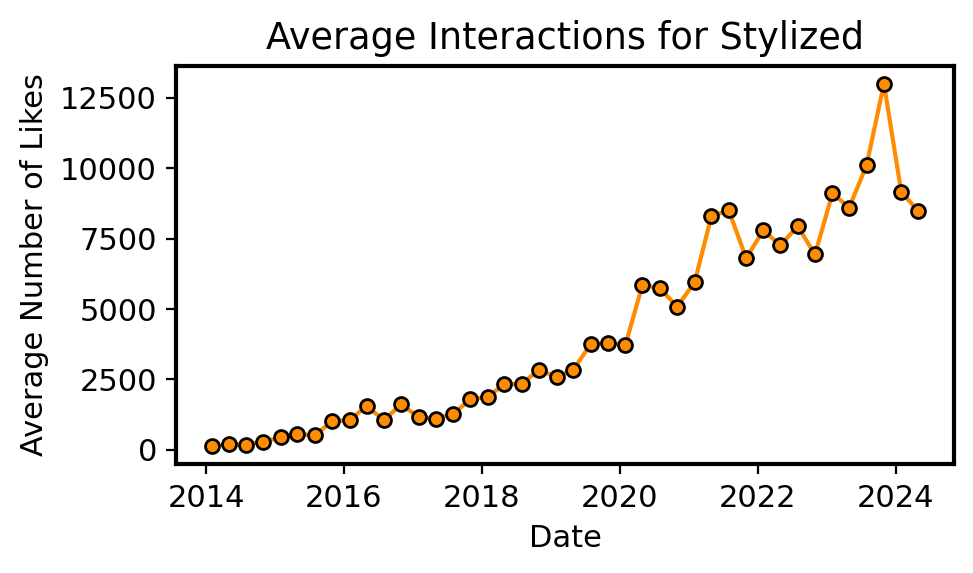

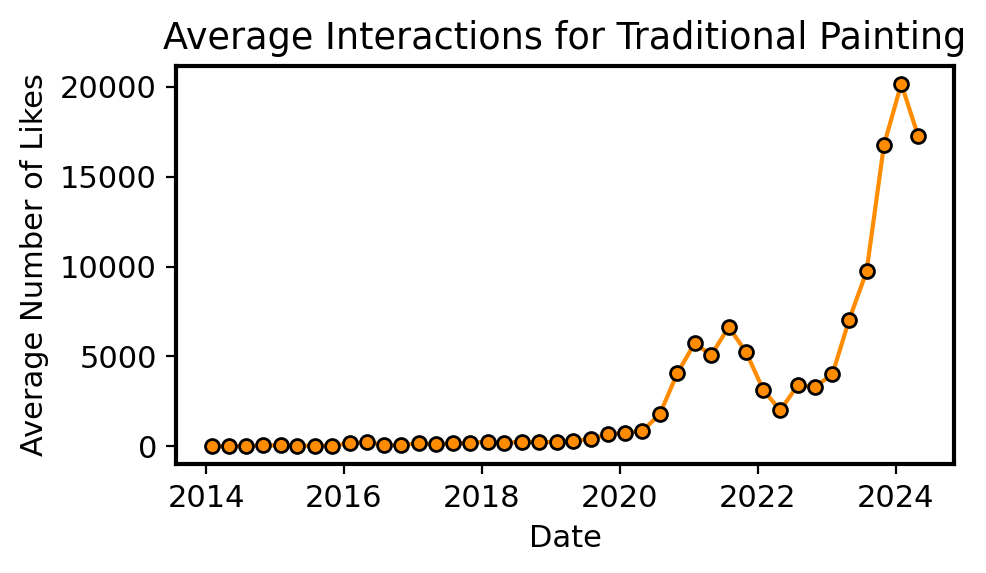

In [84]:
data = []
for d in avgh["post_date"].unique():
    for g in avgh[avgh["post_date"] == d]["genre"].unique():
        data.append([d, g, avgh[(avgh["post_date"] == d) & (avgh["genre"] == g)]["ER"].mean()])
avghf = pd.DataFrame(data, columns=["post_date", "genre", "ER"])
pivot_df = avghf.pivot(index='post_date', columns='genre', values='ER')

# Plotting
for g in pivot_df.columns:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(pivot_df[g], color="darkorange", marker="o", markeredgecolor= "black", markersize = 5)

    ax.set_title(f"Average Interactions for {g}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Number of Likes')
    plt.tight_layout()

In [133]:
merged_dfe["first_post_on_profile"] = ""

for p in merged_dfe["owner_username"].unique():
    merged_dfe.loc[merged_dfe["owner_username"] == p, "first_post_on_profile"] = merged_dfe[merged_dfe["owner_username"] == p]["post_date"].min()


In [134]:
h_mdf.groupby([pd.Grouper(key='post_date', freq=date_freq), pd.cut(merged_dfe['first_post_on_profile'].astype("datetime64[ns]"), 
                    [np.datetime64("2013-12-31"), np.datetime64("2016-01-01"), np.datetime64("2018-01-01"),  np.datetime64("2020-01-01"), np.datetime64("2022-01-01"), np.datetime64("2023-07-01"), np.datetime64("2024-03-31")])], 
                    observed=True).head()



shortcode  owner_user_id          owner_username  num_likes  \
0       C3rTPiIRQNe     7850471928               yukari_ow       2096   
1       C3Z62UKxatp     7850471928               yukari_ow       1426   
2       C3UKvAIxcbn     7850471928               yukari_ow       1774   
3       C3EjyRgxJsV     7850471928               yukari_ow       2255   
4       C26OWBgx1vE     7850471928               yukari_ow        688   
...             ...            ...                     ...        ...   
97809   CcyHMQPPG0y    51762100379  __shashi__artist__4436         16   
97810   CcsZlpMPQHy    51762100379  __shashi__artist__4436         18   
102808  BdllQigj-4k     6547669501       sachinbhojane_art        108   
102809  Bdlk2tmDYpu     6547669501       sachinbhojane_art        116   
102810  Bdle6GpjDH9     6547669501       sachinbhojane_art        123   

        num_comments           post_date  is_reel  is_human_x      user_id  \
0                  5 2024-02-23 04:27:38        0           1   7850471928   
1                  4 2024-02-16 10:27:23        0           1   7850471928   
2                  3 2024-02-14 04:50:45        0           1   7850471928   
3                  4 2024-02-08 03:21:48        0           1   7850471928   
4                  2 2024-02-04 03:02:03        0           1   7850471928   
...              ...                 ...      ...         ...          ...   
97809              4 2022-04-25 17:49:22        0           1  51762100379   
97810              2 2022-04-23 12:34:41        0           1  51762100379   
102808             0 2018-01-06 00:04:09        0           1   6547669501   
102809             1 2018-01-06 00:00:37        0           1   6547669501   
102810             1 2018-01-05 23:08:39        0           1   6547669501   

                      username  num_followers  num_posts  is_human_y   genre  \
0                    yukari_ow           5148         50           1   Anime   
1                    yukari_ow           5148         50           1   Anime   
2                    yukari_ow           5148         50           1   Anime   
3                    yukari_ow           5148         50           1   Anime   
4                    yukari_ow           5148         50           1   Anime   
...                        ...            ...        ...         ...     ...   
97809   __shashi__artist__4436           7089        932           1  Pencil   
97810   __shashi__artist__4436           7089        932           1  Pencil   
102808       sachinbhojane_art          29960        346           1  Pencil   
102809       sachinbhojane_art          29960        346           1  Pencil   
102810       sachinbhojane_art          29960        346           1  Pencil   

          ER  
0       2101  
1       1430  
2       1777  
3       2259  
4        690  
...      ...  
97809     20  
97810     20  
102808   108  
102809   117  
102810   124  

[656 rows x 15 columns]

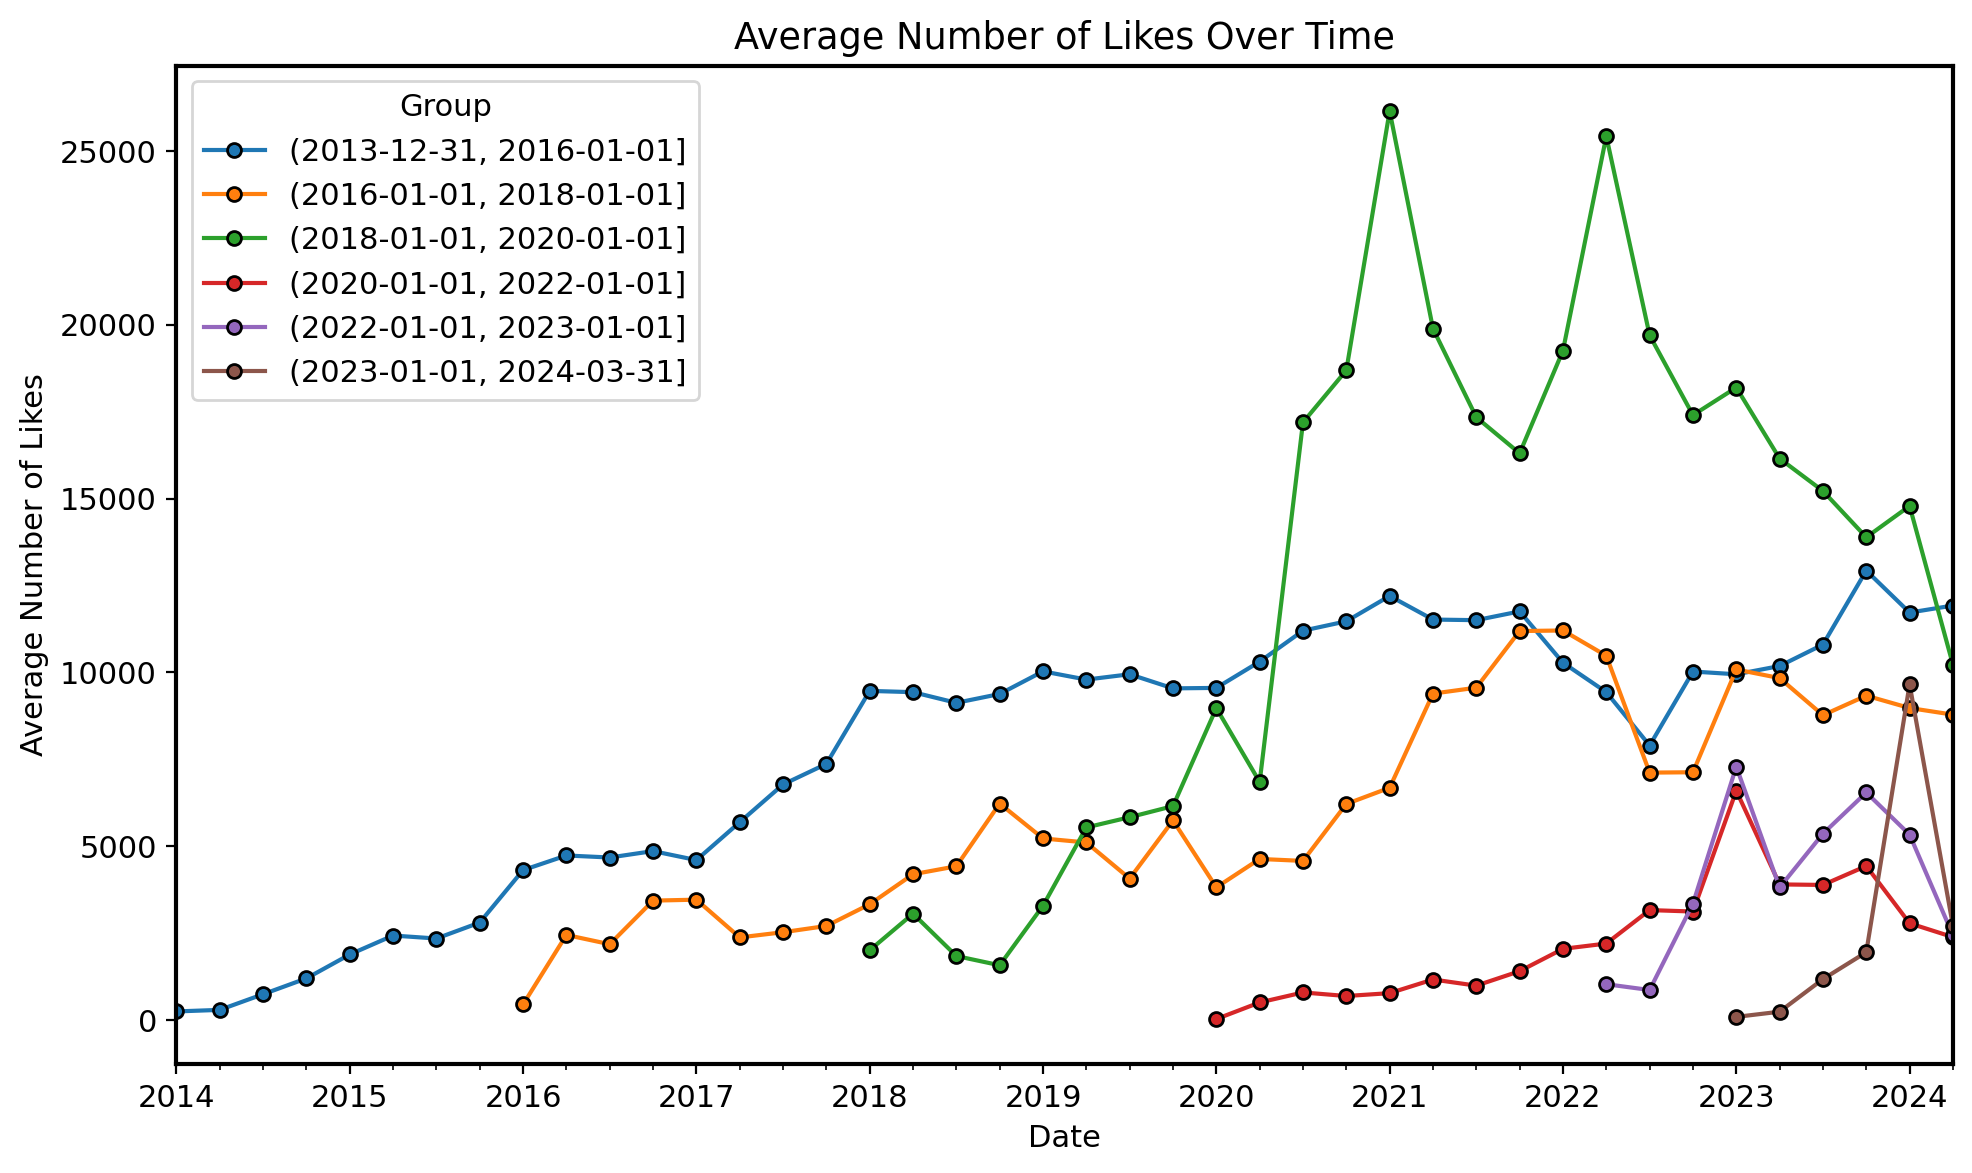

In [135]:
avgh = h_mdf.groupby([pd.Grouper(key='post_date', freq=date_freq), pd.cut(merged_dfe['first_post_on_profile'].astype("datetime64[ns]"), 
                    [np.datetime64("2013-12-31"), np.datetime64("2016-01-01"), np.datetime64("2018-01-01"),  np.datetime64("2020-01-01"), np.datetime64("2022-01-01"), np.datetime64("2023-01-01"), np.datetime64("2024-03-31")])], 
                    observed=True)['ER'].mean().reset_index()


pivot_df = avgh.pivot(index='post_date', columns='first_post_on_profile', values='ER')

# Plotting
pivot_df.plot(kind='line', marker="o", markeredgecolor= "black", markersize= 5, figsize=(10, 6))
plt.title('Average Number of Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Interactions')

plt.legend(title='Group')
plt.tight_layout()
plt.show()

In [157]:
data = []
for user in profiles_df["username"]:
    # data.append(merged_dfe[merged_dfe["owner_username"] == user]["first_post_on_profile"][0])
    try:
        date = merged_dfe[merged_dfe["owner_username"] == user]["first_post_on_profile"].iloc[0]
        data.append(date)
    except Exception as e:
        data.append(pd.NaT)

profiles_df["date_started"] = pd.Series(data)


hpdf = profiles_df[(profiles_df["is_human"] == 1)]

In [187]:
hpdf = profiles_df[(profiles_df["is_human"] == 1)]

In [190]:
hpdf = hpdf[(hpdf["date_started"] < "2020")]

hpdf["genre"].value_counts()

genre
Stylized                 13
Traditional Painting     10
Comic                    10
Digital Painting          9
Environment/Landscape     8
Fantasy                   8
Fashion                   8
Mecha                     8
Horror                    7
Cartoon                   7
Semi Realism              6
Pencil                    6
Anime                     5
Character Design          5
Portrait                  5
Pixel                     3
Name: count, dtype: int64

In [49]:
genres = np.intersect1d(ai_mdf["genre"].unique(), h_mdf["genre"].unique())

Anime


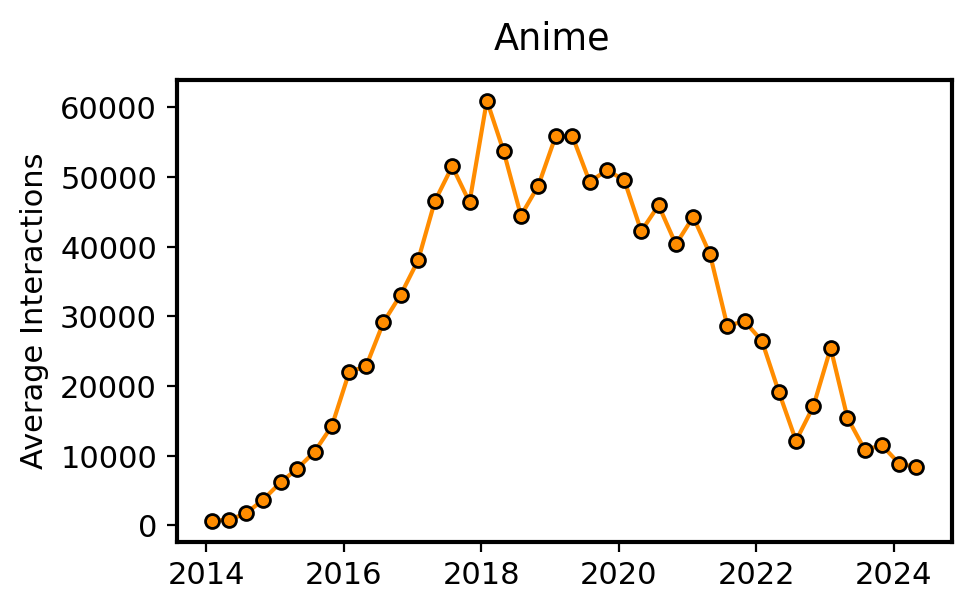

Character Design


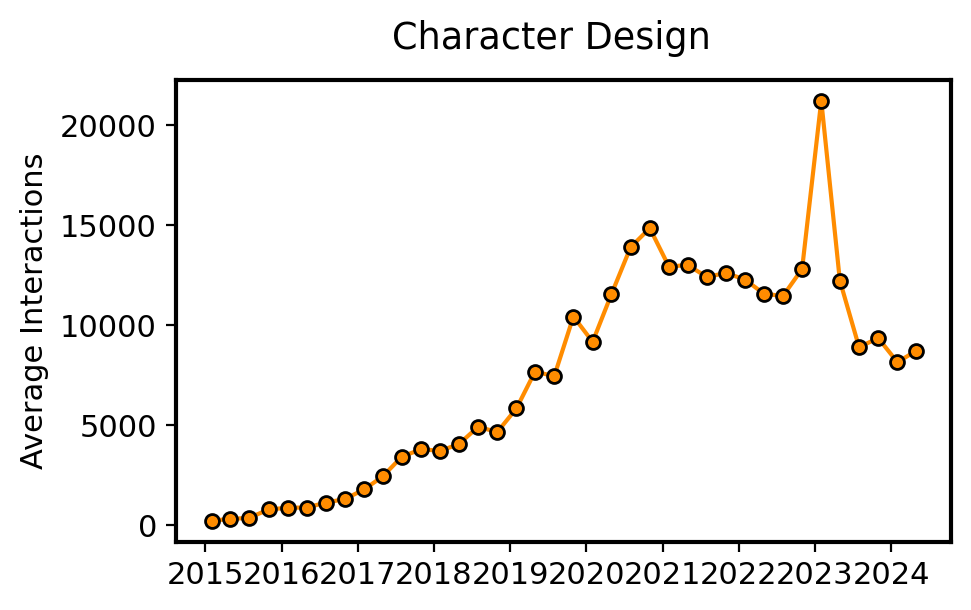

Environment/Landscape


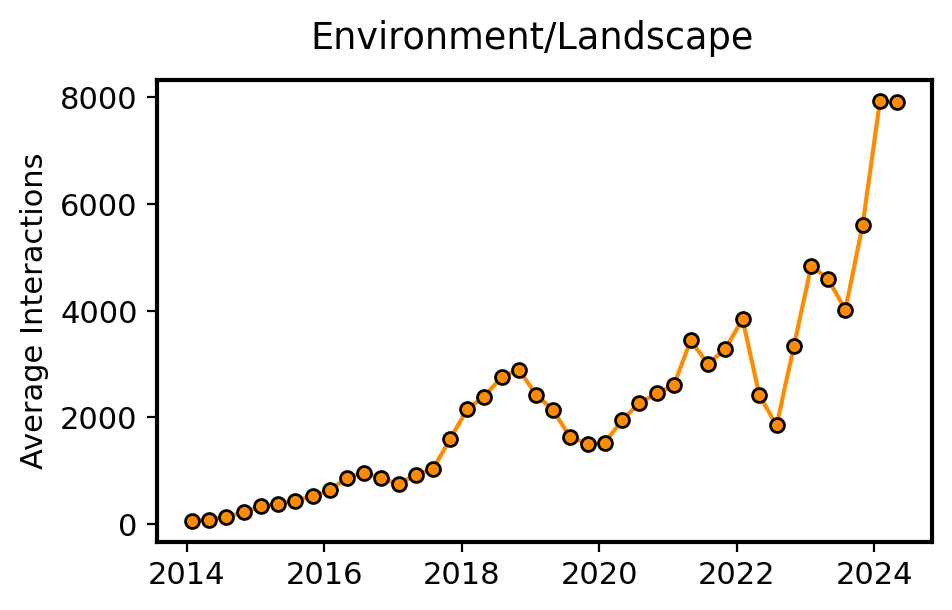

Fantasy


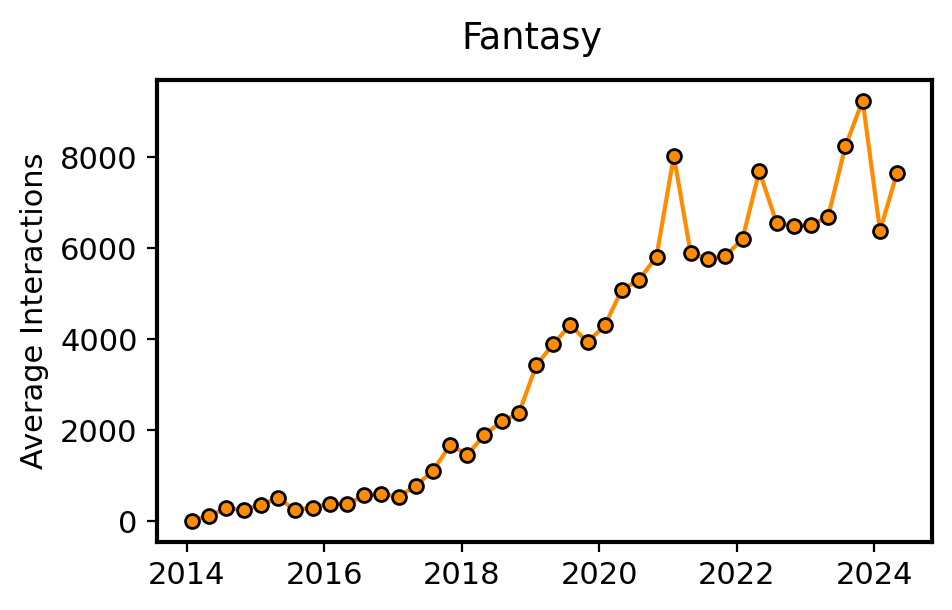

Fashion


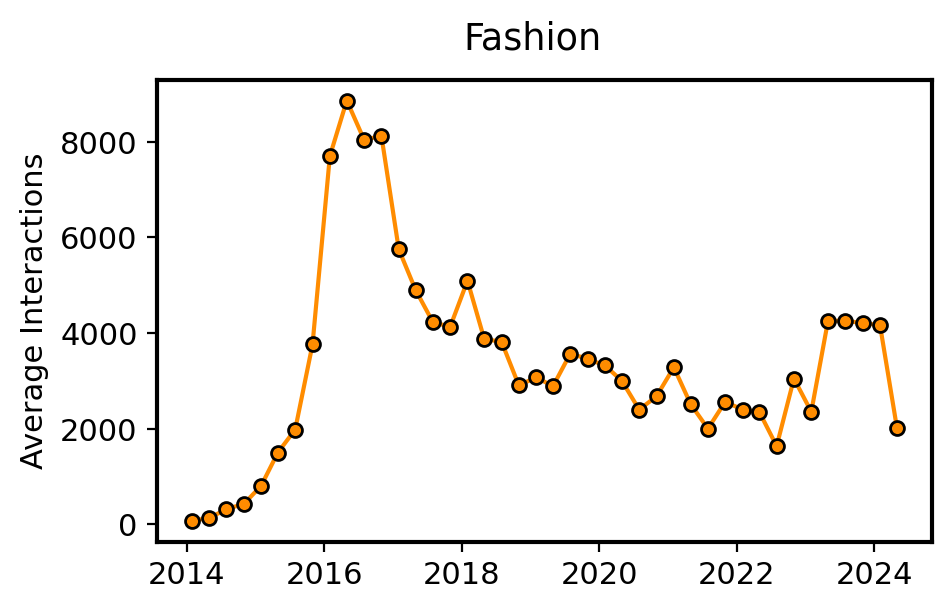

Horror


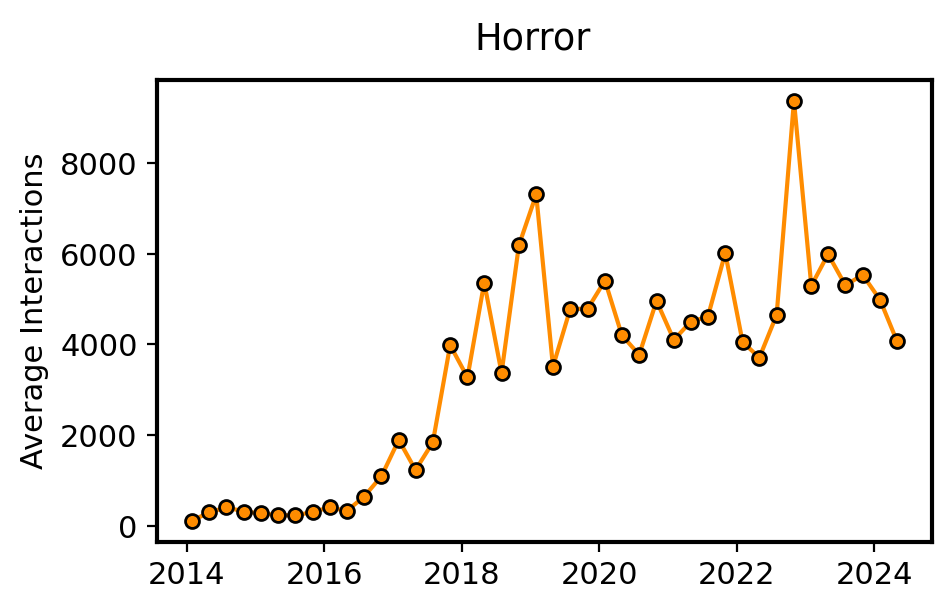

Mecha


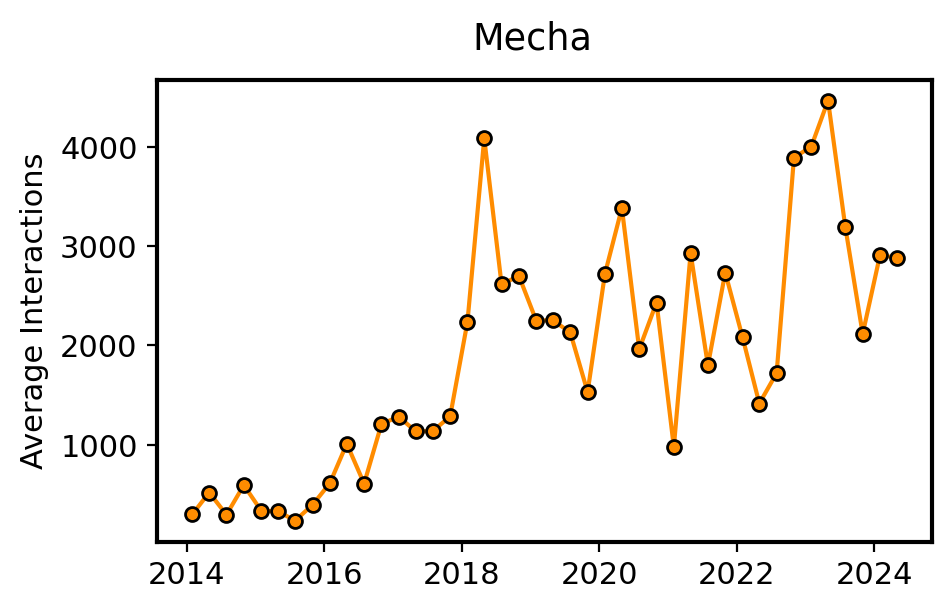

Portrait


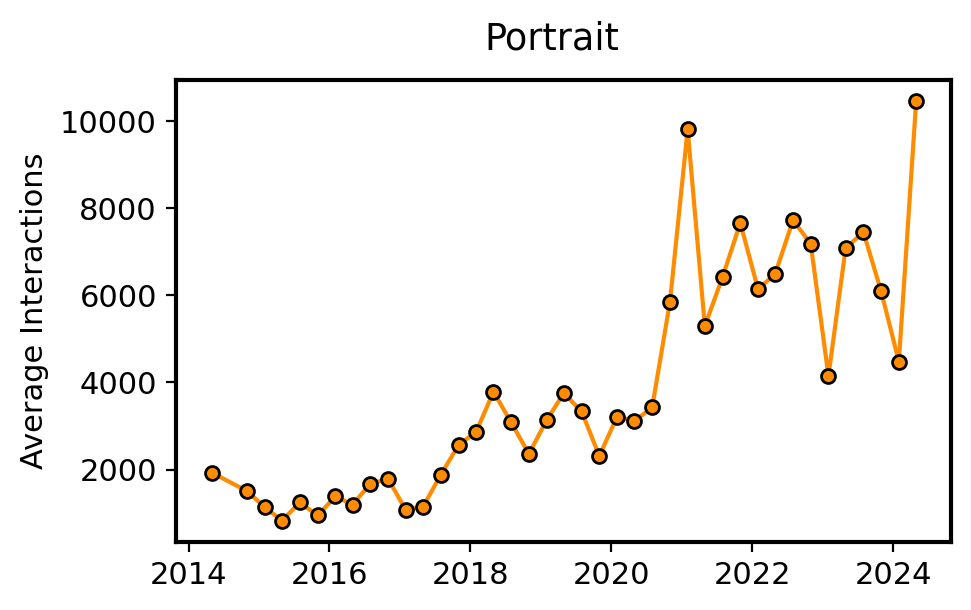

Semi Realism


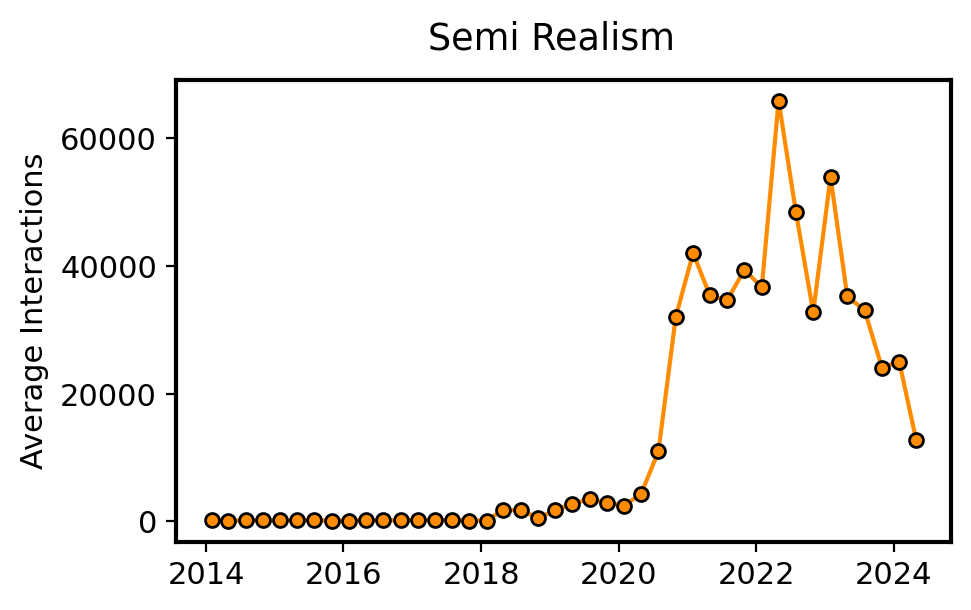

Stylized


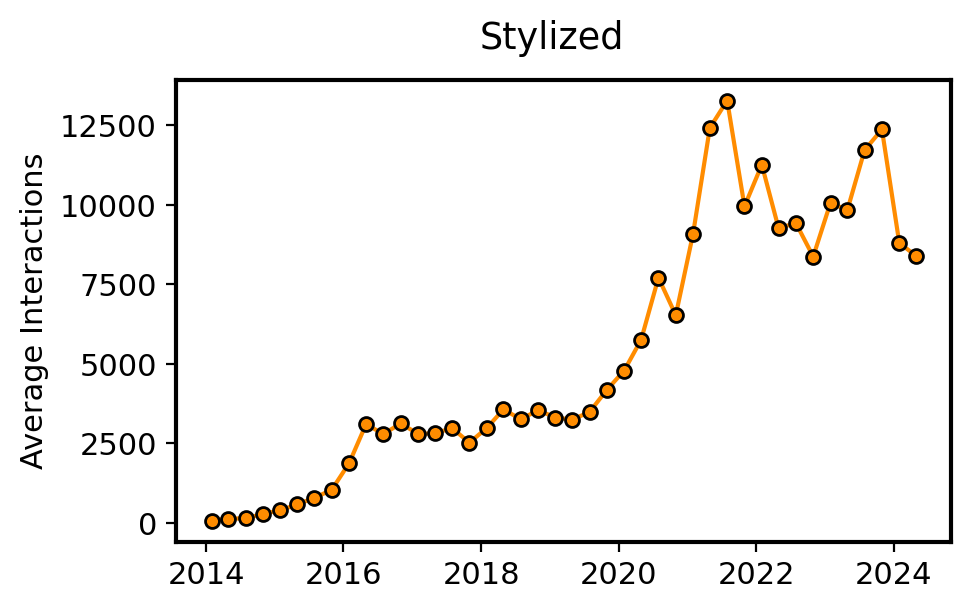

Traditional Painting


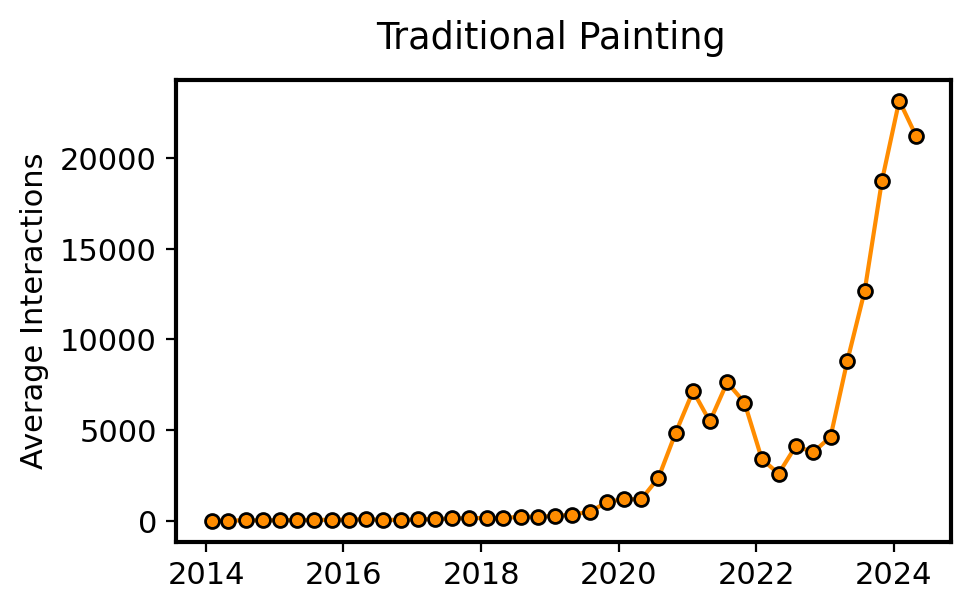

In [54]:
from operator import attrgetter
# ai_avg_likes = ai_mdf.groupby(['genre', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].mean().reset_index()
h_avg_likes = h_mdf.groupby(['genre', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].mean().reset_index()

since = pd.to_datetime("2013-1-1").to_period(date_freq)
for g in genres:
    print(g)
    fig, ax1 = plt.subplots(figsize=(5,3))

    h = h_avg_likes[h_avg_likes["genre"] == g]
    ax1.plot(h["post_date"], h["num_likes"], color="darkorange", marker="o", markeredgecolor= "black", markersize = 5)
    ax1.set_ylabel("Average Interactions")
    fig.suptitle(g)
    # fig.set_size(10,6)
    plt.show()

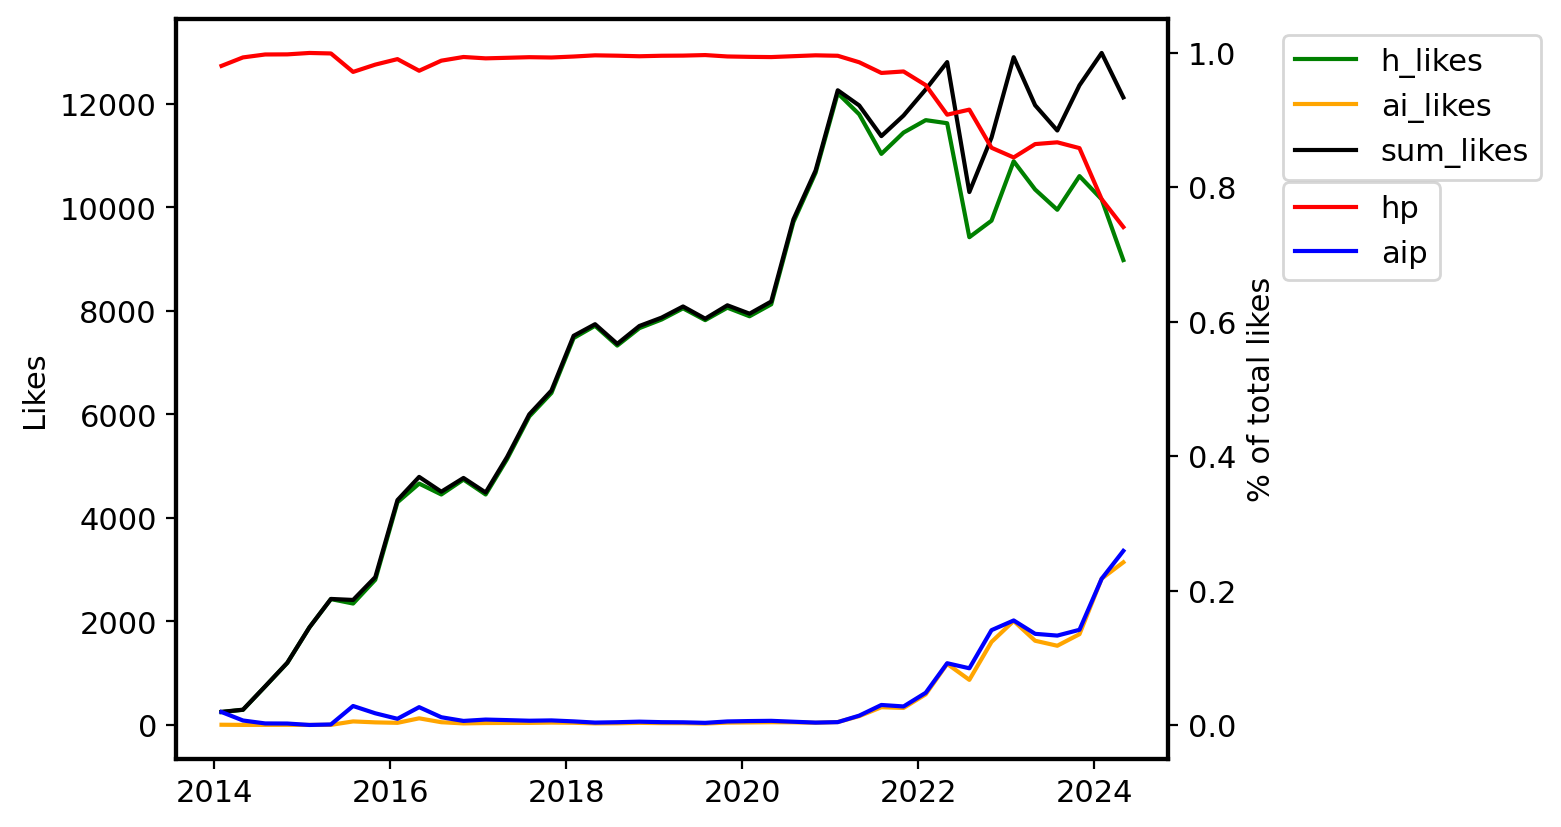

In [529]:

avg_likes = merged_dfe.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)])['ER'].mean().reset_index()
pivot_df = avg_likes.pivot(index='post_date', columns='is_human_x', values='ER')
fig, ax = plt.subplots()
sum_likes = pivot_df[0] + pivot_df[1]
ax2 = ax.twinx()
ax.plot(pivot_df[1].index, pivot_df[1], color='green', label= "h_likes")
ax.plot(pivot_df[0].index, pivot_df[0], color='orange', label= "ai_likes")
ax.plot(pivot_df[0].index, sum_likes, color='black', label= "sum_likes")

ax2.plot(pivot_df[1].index, pivot_df[1]/sum_likes, color='red', label= "hp")
ax2.plot(pivot_df[0].index, pivot_df[0]/sum_likes, color='blue', label= "aip")
# ax.set_xlabel("Months since " + str(since))
ax.set_ylabel("Likes")
ax2.set_ylabel("% of total likes")#, rotation= 270)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.8))